# Logit Lens and Direct Logit Attribution

In this notebook we explore how the model is doing prediction of the first path token in the maze (ie. the token that immediately comes after the `PATH_START` token), to this end we use:

* Logit Lens
* Direct Logit Attribution
* Activation Patching

In summary, we find that the majority of computation associated with this task is in the form of MLP computation (in particular in MLP10 and MLP11) but that there does appear to be a few heads within early layers (Layer 0, 1 and 2) that are also playing some role. Further evals outside of this notebook however are suggestive of this instance of maze-transformer doing some form of memorization (atleast overfitting to its training data and not generalising OOD), for this reason, this study has not yet been taken further.

This notebook takes significant inspiration from two great resources:

* Nanda's [Exploratory Analysis Demo](https://github.com/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb) Notebook
* Janiak & Heimersheim's [Python docstrings](https://colab.research.google.com/drive/17CoA1yARaWHvV14zQGcI3ISz1bIRZKS5) Notebook

# Setup

In [1]:
# Generic
import os
from pathlib import Path
from copy import deepcopy
import typing

# Numerical Computing
import numpy as np
import torch
import pandas as pd
from jaxtyping import Float, Int, Bool
import matplotlib.pyplot as plt
import seaborn as sns

from muutils.misc import shorten_numerical_to_str
from muutils.nbutils.configure_notebook import configure_notebook, plotshow
from muutils.tensor_utils import string_dict_shapes
# TransformerLens imports
from transformer_lens import ActivationCache, HookedTransformer

# Our Code
# dataset stuff
from maze_dataset import MazeDataset, MazeDatasetConfig, SolvedMaze, LatticeMaze, SPECIAL_TOKENS, LatticeMazeGenerators
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode
from maze_dataset.plotting.print_tokens import color_maze_tokens_AOTP

# model stuff
from maze_transformer.training.config import ConfigHolder, ZanjHookedTransformer, BaseGPTConfig

# mechinterp stuff
from maze_transformer.mechinterp.plot_logits import plot_logits
from maze_transformer.mechinterp.logit_attrib_task import DLAProtocol, DLAProtocolFixed, token_after_fixed_start_token, LOGIT_ATTRIB_TASKS
from maze_transformer.mechinterp.logit_diff import logits_diff_multi
from maze_transformer.mechinterp.logit_lens import plot_logit_lens
from maze_transformer.mechinterp.direct_logit_attribution import plot_direct_logit_attribution
from maze_transformer.mechinterp.plot_attention import plot_attention_final_token
from maze_transformer.mechinterp.plot_weights import plot_important_neurons
from maze_transformer.evaluation.load_model_testdata import load_model_with_test_data



c:\Users\mivan\AppData\Local\pypoetry\Cache\virtualenvs\understanding-search-experiments-1eWz7Qts-py3.11\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
# Setup (we won't be training any models)
DEVICE: torch.device = configure_notebook(seed=43, dark_mode=False, plot_mode="save", fig_output_fmt="pdf", fig_basepath="figures")
print(f"{DEVICE = }")
torch.set_grad_enabled(False)


Figures will be saved to: 'figures'
set up plots with PLOT_MODE = 'save', FIG_OUTPUT_FMT = 'tex', FIG_BASEPATH = 'figures'
DEVICE = device(type='cuda')


## Loading the model and dataset in

In [3]:
MODEL: ZanjHookedTransformer; DATASET: MazeDataset
MODEL, DATASET = load_model_with_test_data(
	# model_path="../examples/wandb.jerpkipj.zanj",
	# model_path="../examples/model.hallway-insto.v17.zanj",
	model_path="../examples/model.hallway-jvq.final.zanj",
	dataset_cfg_source=MazeDatasetConfig(
		name="hallway",
		grid_n=7,
		n_mazes=50,
		maze_ctor=LatticeMazeGenerators.gen_dfs,
		maze_ctor_kwargs=dict(do_forks=False),
		seed=43,
	),
	n_examples=50,
)

F:\KNC\maze-dataset\maze_dataset\dataset\dataset.py:61: UserWarning:

in GPTDatasetConfig self.name='hallway', self.seed=43 is trying to override GLOBAL_SEED=42 which has already been changed elsewhere from DEFAULT_SEED=42



loaded model with 1.2M params (num_params = 1238076) from:
	path: ../models/model.hallway-jvq.final.zanj
	original model name: 'model.zanj_model_config.name = 'hallway_v3'', changing to 'hallway-jvq.final'
	model tensors on devices: {device(type='cuda', index=0)}
loaded dataset with 200 examples
dataset.cfg.summary() = {'name': 'hallway', 'fname': 'hallway-g7-n200-a_dfs-h12736', 'sdc_hash': 28873668702348942363820530582087178120863432918308260517317237820927875012736, 'seed': 43, 'seq_len_min': 1, 'seq_len_max': 512, 'applied_filters': [], 'grid_n': 7, 'grid_shape': (7, 7), 'n_mazes': 200, 'maze_ctor_name': 'gen_dfs', 'maze_ctor_kwargs': {'do_forks': False}}


## task configuration

In [4]:
# print the available logit attribution tasks
print(f"{list(LOGIT_ATTRIB_TASKS.keys()) = }")

list(LOGIT_ATTRIB_TASKS.keys()) = ['path_start', 'origin_after_path_start', 'first_path_choice', 'path_end', 'final_before_path_end', 'rand_path_token', 'rand_path_token_non_endpoint']


expected tasks:
```
['path_start', 'origin_after_path_start', 'first_path_choice', 'path_end', 'final_before_path_end', 'rand_path_token', 'rand_path_token_non_endpoint']
```

In [5]:
# task to perform
LOGIT_ATTRIBUTION_TASK_NAME: str = "rand_path_token_non_endpoint"
# if you have a custom task, set it here -- otherwise we will attempt to load one of the known tasks
LOGIT_ATTRIBUTION_TASK: DLAProtocolFixed|None = None
if LOGIT_ATTRIBUTION_TASK is None:
    LOGIT_ATTRIBUTION_TASK = LOGIT_ATTRIB_TASKS[LOGIT_ATTRIBUTION_TASK_NAME]

## Dataset Creation

Creating a collection of mazes to have the model predict on

In [6]:
TOKENIZER: MazeTokenizer = MODEL.zanj_model_config.maze_tokenizer
DATASET_TOKENS: list[list[str]] = DATASET.as_tokens(TOKENIZER, join_tokens_individual_maze=False)

# print some info
print(f"loaded {len(DATASET_TOKENS)} mazes")
print(f"first maze:\n{' '.join(DATASET_TOKENS[0])}")
print(f"first maze, colored:\n{color_maze_tokens_AOTP(DATASET_TOKENS[0], fmt='terminal')}")

loaded 200 mazes
first maze:
<ADJLIST_START> (2,0) <--> (1,0) ; (4,0) <--> (4,1) ; (5,2) <--> (4,2) ; (3,2) <--> (3,1) ; (0,0) <--> (0,1) ; (4,1) <--> (5,1) ; (1,2) <--> (1,3) ; (0,1) <--> (0,2) ; (3,3) <--> (3,2) ; (0,3) <--> (0,2) ; (5,3) <--> (4,3) ; (4,3) <--> (4,2) ; (5,4) <--> (4,4) ; (6,4) <--> (6,3) ; (3,0) <--> (3,1) ; (5,3) <--> (6,3) ; (6,1) <--> (6,2) ; (1,1) <--> (1,2) ; (6,4) <--> (5,4) ; (6,2) <--> (5,2) ; (2,0) <--> (3,0) ; (3,4) <--> (4,4) ; (0,3) <--> (1,3) ; (3,4) <--> (3,3) ; (5,1) <--> (6,1) ; (1,0) <--> (1,1) ; <ADJLIST_END> <ORIGIN_START> (0,3) <ORIGIN_END> <TARGET_START> (3,3) <TARGET_END> <PATH_START> (0,3) (1,3) (1,2) (1,1) (1,0) (2,0) (3,0) (3,1) (3,2) (3,3) <PATH_END>
first maze, colored:
<ADJLIST_START> (2,0) <--> (1,0) ; (4,0) <--> (4,1) ; (5,2) <--> (4,2) ; (3,2) <--> (3,1) ; (0,0) <--> (0,1) ; (4,1) <--> (5,1) ; (1,2) <--> (1,3) ; (0,1) <--> (0,2) ; (3,3) <--> (3,2) ; (0,3) <--> (0,2) ; (5,3) <--> (4,3) ; (4,3) <--> (4,2) ; (5,4) <--> (4,4) ; (6,4) <--> 

process the data into prompts and targets

In [7]:
# process with the task
DATASET_PROMPTS: list[list[str]]; DATASET_TARGETS: list[str]
DATASET_PROMPTS, DATASET_TARGETS = LOGIT_ATTRIBUTION_TASK(DATASET_TOKENS)

DATASET_PROMPTS_JOINED: list[str] = [" ".join(prompt) for prompt in DATASET_PROMPTS]
DATASET_TARGET_IDS: Float[torch.Tensor, "n_mazes"] = torch.tensor(TOKENIZER.encode(DATASET_TARGETS), dtype=torch.long).cpu()

# print("for first maze:")
# print(f"full:\n{' '.join(DATASET_PROMPTS[0])}")
# print(f"prompt:\n{'[...] ' + DATASET_PROMPTS_JOINED[0][-150:]}")
# print(f"target:\n{DATASET_TARGETS[0]}")
# print(f"target id:\n{DATASET_TARGET_IDS[0]}")
# plt.imshow(DATASET[0].as_pixels())

n_mazes: int = len(DATASET_TOKENS)
d_vocab: int = TOKENIZER.vocab_size

# run model

In [8]:
LOGITS: Float[torch.Tensor, "n_mazes seq_len d_vocab"]
CACHE: ActivationCache
LOGITS, CACHE = MODEL.run_with_cache(DATASET_PROMPTS_JOINED)

In [9]:
print(f"{n_mazes = }, {d_vocab = }")
print(f"{LOGITS.shape = }")
cache_shapes: dict[str, tuple[int, ...]] = {k: v.shape for k, v in CACHE.items()}
print(f"{cache_shapes = }")

n_mazes = 200, d_vocab = 60
LOGITS.shape = torch.Size([200, 201, 60])
cache_shapes = {'hook_embed': torch.Size([200, 201, 128]), 'hook_pos_embed': torch.Size([200, 201, 128]), 'blocks.0.hook_resid_pre': torch.Size([200, 201, 128]), 'blocks.0.ln1.hook_scale': torch.Size([200, 201, 1]), 'blocks.0.ln1.hook_normalized': torch.Size([200, 201, 128]), 'blocks.0.attn.hook_q': torch.Size([200, 201, 4, 32]), 'blocks.0.attn.hook_k': torch.Size([200, 201, 4, 32]), 'blocks.0.attn.hook_v': torch.Size([200, 201, 4, 32]), 'blocks.0.attn.hook_attn_scores': torch.Size([200, 4, 201, 201]), 'blocks.0.attn.hook_pattern': torch.Size([200, 4, 201, 201]), 'blocks.0.attn.hook_z': torch.Size([200, 201, 4, 32]), 'blocks.0.hook_attn_out': torch.Size([200, 201, 128]), 'blocks.0.hook_resid_mid': torch.Size([200, 201, 128]), 'blocks.0.ln2.hook_scale': torch.Size([200, 201, 1]), 'blocks.0.ln2.hook_normalized': torch.Size([200, 201, 128]), 'blocks.0.mlp.hook_pre': torch.Size([200, 201, 512]), 'blocks.0.mlp.hook_post':

we expect the logits to have shape `(n_mazes, n_tokens, n_vocab)`


## get and evaluate predictions

these should have shape `(n_mazes, n_vocab)`

In [10]:
LAST_TOK_LOGITS: Float[torch.Tensor, "n_mazes d_vocab"] = LOGITS[:, -1, :].cpu()
print(f"{LAST_TOK_LOGITS.shape = }")

LAST_TOK_LOGITS.shape = torch.Size([200, 60])


In [11]:
PREDICTED_TOKENS: list[str] = TOKENIZER.decode(LAST_TOK_LOGITS.argmax(dim=-1).tolist())
print(f"{len(PREDICTED_TOKENS) = }")
print(f"{DATASET_TARGETS[0] = }")
print(f"{PREDICTED_TOKENS[0] = }")

len(PREDICTED_TOKENS) = 200
DATASET_TARGETS[0] = '(2,0)'
PREDICTED_TOKENS[0] = '(2,0)'


overall task accuracy

In [12]:
prediction_correct: Bool[torch.Tensor, "n_mazes"] = torch.tensor([
	pred == target 
	for pred, target in zip(PREDICTED_TOKENS, DATASET_TARGETS)
])

# print(f"{prediction_correct.shape = }")
print(f"{prediction_correct.float().mean().item() = }")

prediction_correct.float().mean().item() = 0.9750000238418579


# Results

## logit diff

A logit difference $d$ can be interpreted as the model being $e^{d}$ times more likely to choose the correct response. Here, the `test` column tells us what token we are comparing: `taget` (correct) token, `predicted` (argmax sample) token, and `sampled` (sampled from logits) token. Also included are `noise={p}` (predicted with gaussian noise added to logits) and `random_r{i}` (a fully random one-hot vector). We compare these to either `all` other logits, or a `random` other vector.

In [13]:
# fig, (ax_all, ax_hist) = plot_logits(
#     last_tok_logits=LAST_TOK_LOGITS,
#     target_idxs=DATASET_TARGET_IDS,
#     tokenizer=TOKENIZER,
#     n_bins=50,
#     density=False,
#     logy=True,
#     show=False,
# )
# # ax_all.set_title(f"logits for last token\nmodel: {MODEL_PATH}\ntask: {LOGIT_ATTRIBUTION_TASK_NAME}")
# # ax_hist.set_title(f"logit histogram\nmodel: {MODEL_PATH}\ntask: {LOGIT_ATTRIBUTION_TASK_NAME}")
# plt.show()

In [14]:
# LOGIT_DIFF_DF: pd.DataFrame = logits_diff_multi(
# 	model=MODEL,
# 	cache=CACHE,
# 	dataset_target_ids=DATASET_TARGET_IDS,
# 	last_tok_logits=LAST_TOK_LOGITS,
# 	# noise_sigmas=np.logspace(0, 3, 100),
# )

# print(LOGIT_DIFF_DF)

# # scatter separately for "all" vs "random"
# fig, ax = plt.subplots()
# for compare_to in ["all", "random"]:
# 	df = LOGIT_DIFF_DF[LOGIT_DIFF_DF["compare_to"] == compare_to]
# 	ax.scatter(
# 		df['result_orig'], df['result_res'], 
# 		label=f"comparing to {compare_to}",
# 		marker='o',
# 	)
# ax.legend()
# plt.xlabel('result_orig')
# plt.ylabel('result_res')
# plt.title('Scatter Plot between result_orig and result_res')
# plt.show()


## logit lens

Here, we test the logit difference of the correct token at various layers

In [15]:
# figax, results = plot_logit_lens(
#     model=MODEL,
#     cache=CACHE,
#     answer_tokens=DATASET_TARGET_IDS,
#     show=False,
# )
# plt.show()

## direct logit attribution

answer_tokens.shape = torch.Size([200])
n_layers = 6, n_heads = 4, d_model = 128
n_layers * n_heads = 24
n_layers * mlp_dim = 3072
Tried to stack head results when they weren't cached. Computing head results now
per_head_residual.shape = torch.Size([24, 200, 128])
per_head_logit_diffs.shape = torch.Size([24])
per_head_logit_diffs.shape = torch.Size([6, 4])


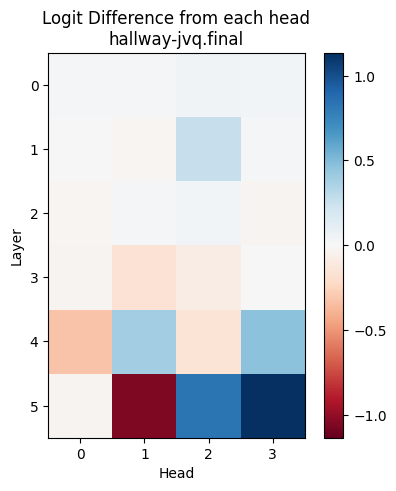

In [16]:
fig, ax, DLA_DATA = plot_direct_logit_attribution(
	model=MODEL,
	cache=CACHE,
    answer_tokens=DATASET_TARGET_IDS,
    show=False,
	# layer_index_normalization=lambda contrib, layer_index: contrib / ((layer_index+1)**2),
)
# ax.set_title(LOGIT_ATTRIBUTION_TASK_NAME)
# fig.savefig(f"{MODEL.config.name}.{DATASET.cfg.to_fname()}.{LOGIT_ATTRIBUTION_TASK_NAME}.dla_heads.pdf", bbox_inches='tight')
# plt.show()

In [17]:
# plot_important_neurons(
#     MODEL,
#     layer=-1,
#     neuron_dla_data=DLA_DATA["neurons"],
#     n_important_neurons=50,
# )

In [18]:
# let's try to plot the values of the attention heads for the top and bottom n contributing heads
# (layer, head, value)
top_heads: int = 10
important_heads: list[tuple[int, int, torch.Tensor]] = sorted(
    [
        (i, j, DLA_DATA["heads"][i, j])
        for i in range(DLA_DATA["heads"].shape[0])
        for j in range(DLA_DATA["heads"].shape[1])
	],
    key=lambda x: abs(x[2]),
    reverse=True,
)[:top_heads]
print(f"{important_heads = }")

# plot the attention heads
print(f"{CACHE.keys() = }")
important_heads_scores = {
    f"layer_{i}.head_{j}": (
        c,
        CACHE[f'blocks.{i}.attn.hook_attn_scores'][:, j, :, :].cpu().numpy(),
    )
    for i, j, c in important_heads
}

print("="*80)


important_heads = [(5, 3, 1.1349827), (5, 1, -1.0604424), (5, 2, 0.8314017), (4, 3, 0.46919096), (4, 1, 0.3916713), (4, 0, -0.3201226), (1, 2, 0.26551077), (3, 1, -0.16694348), (4, 2, -0.15300508), (3, 2, -0.08092911)]
CACHE.keys() = dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_

--------------------------------------------------------------------------------
head: layer_5.head_3, score: c = 1.1349827, attn_presoftmax.shape = (200, 201, 201)
<--> (6,1) ; (1,0) <--> (1,1) ; <ADJLIST_END> <ORIGIN_START> (0,3) <ORIGIN_END> <TARGET_START> (3,3) <TARGET_END> <PATH_START> (0,3) (1,3) (1,2) (1,1) (1,0)
0.0  0.0     0.1   0.0  0.3     0.0           0.0            0.0   0.0          0.0            0.0   0.0          0.0          0.0   0.0   0.0   0.0   0.0   
AxesSubplot(0.125,0.11;0.133621x0.77)
self.hide_colorbar = True
<--> (3,0) ; (2,0) <--> (2,1) ; <ADJLIST_END> <ORIGIN_START> (4,5) <ORIGIN_END> <TARGET_START> (2,1) <TARGET_END> <PATH_START> (4,5) (5,5) (5,6) (4,6) (3,6)
0.0  0.0     0.0   0.0  0.0     0.0           0.0            0.0   0.0          0.0            0.0   0.0          0.0          0.0   0.0   0.0   0.1   0.0   
AxesSubplot(0.285345,0.11;0.133621x0.77)
self.hide_colorbar = True
(0,1) ; (2,0) <--> (2,1) ; (5,2) <--> (6,2) ; <ADJLIST_END> <ORIGIN_START>

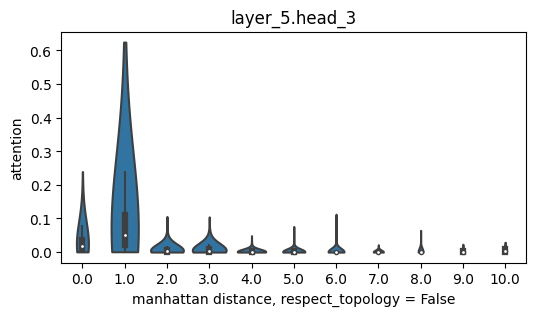

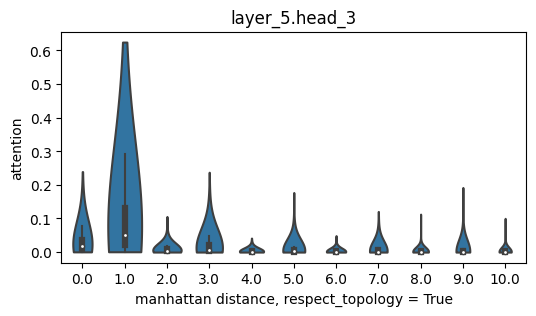

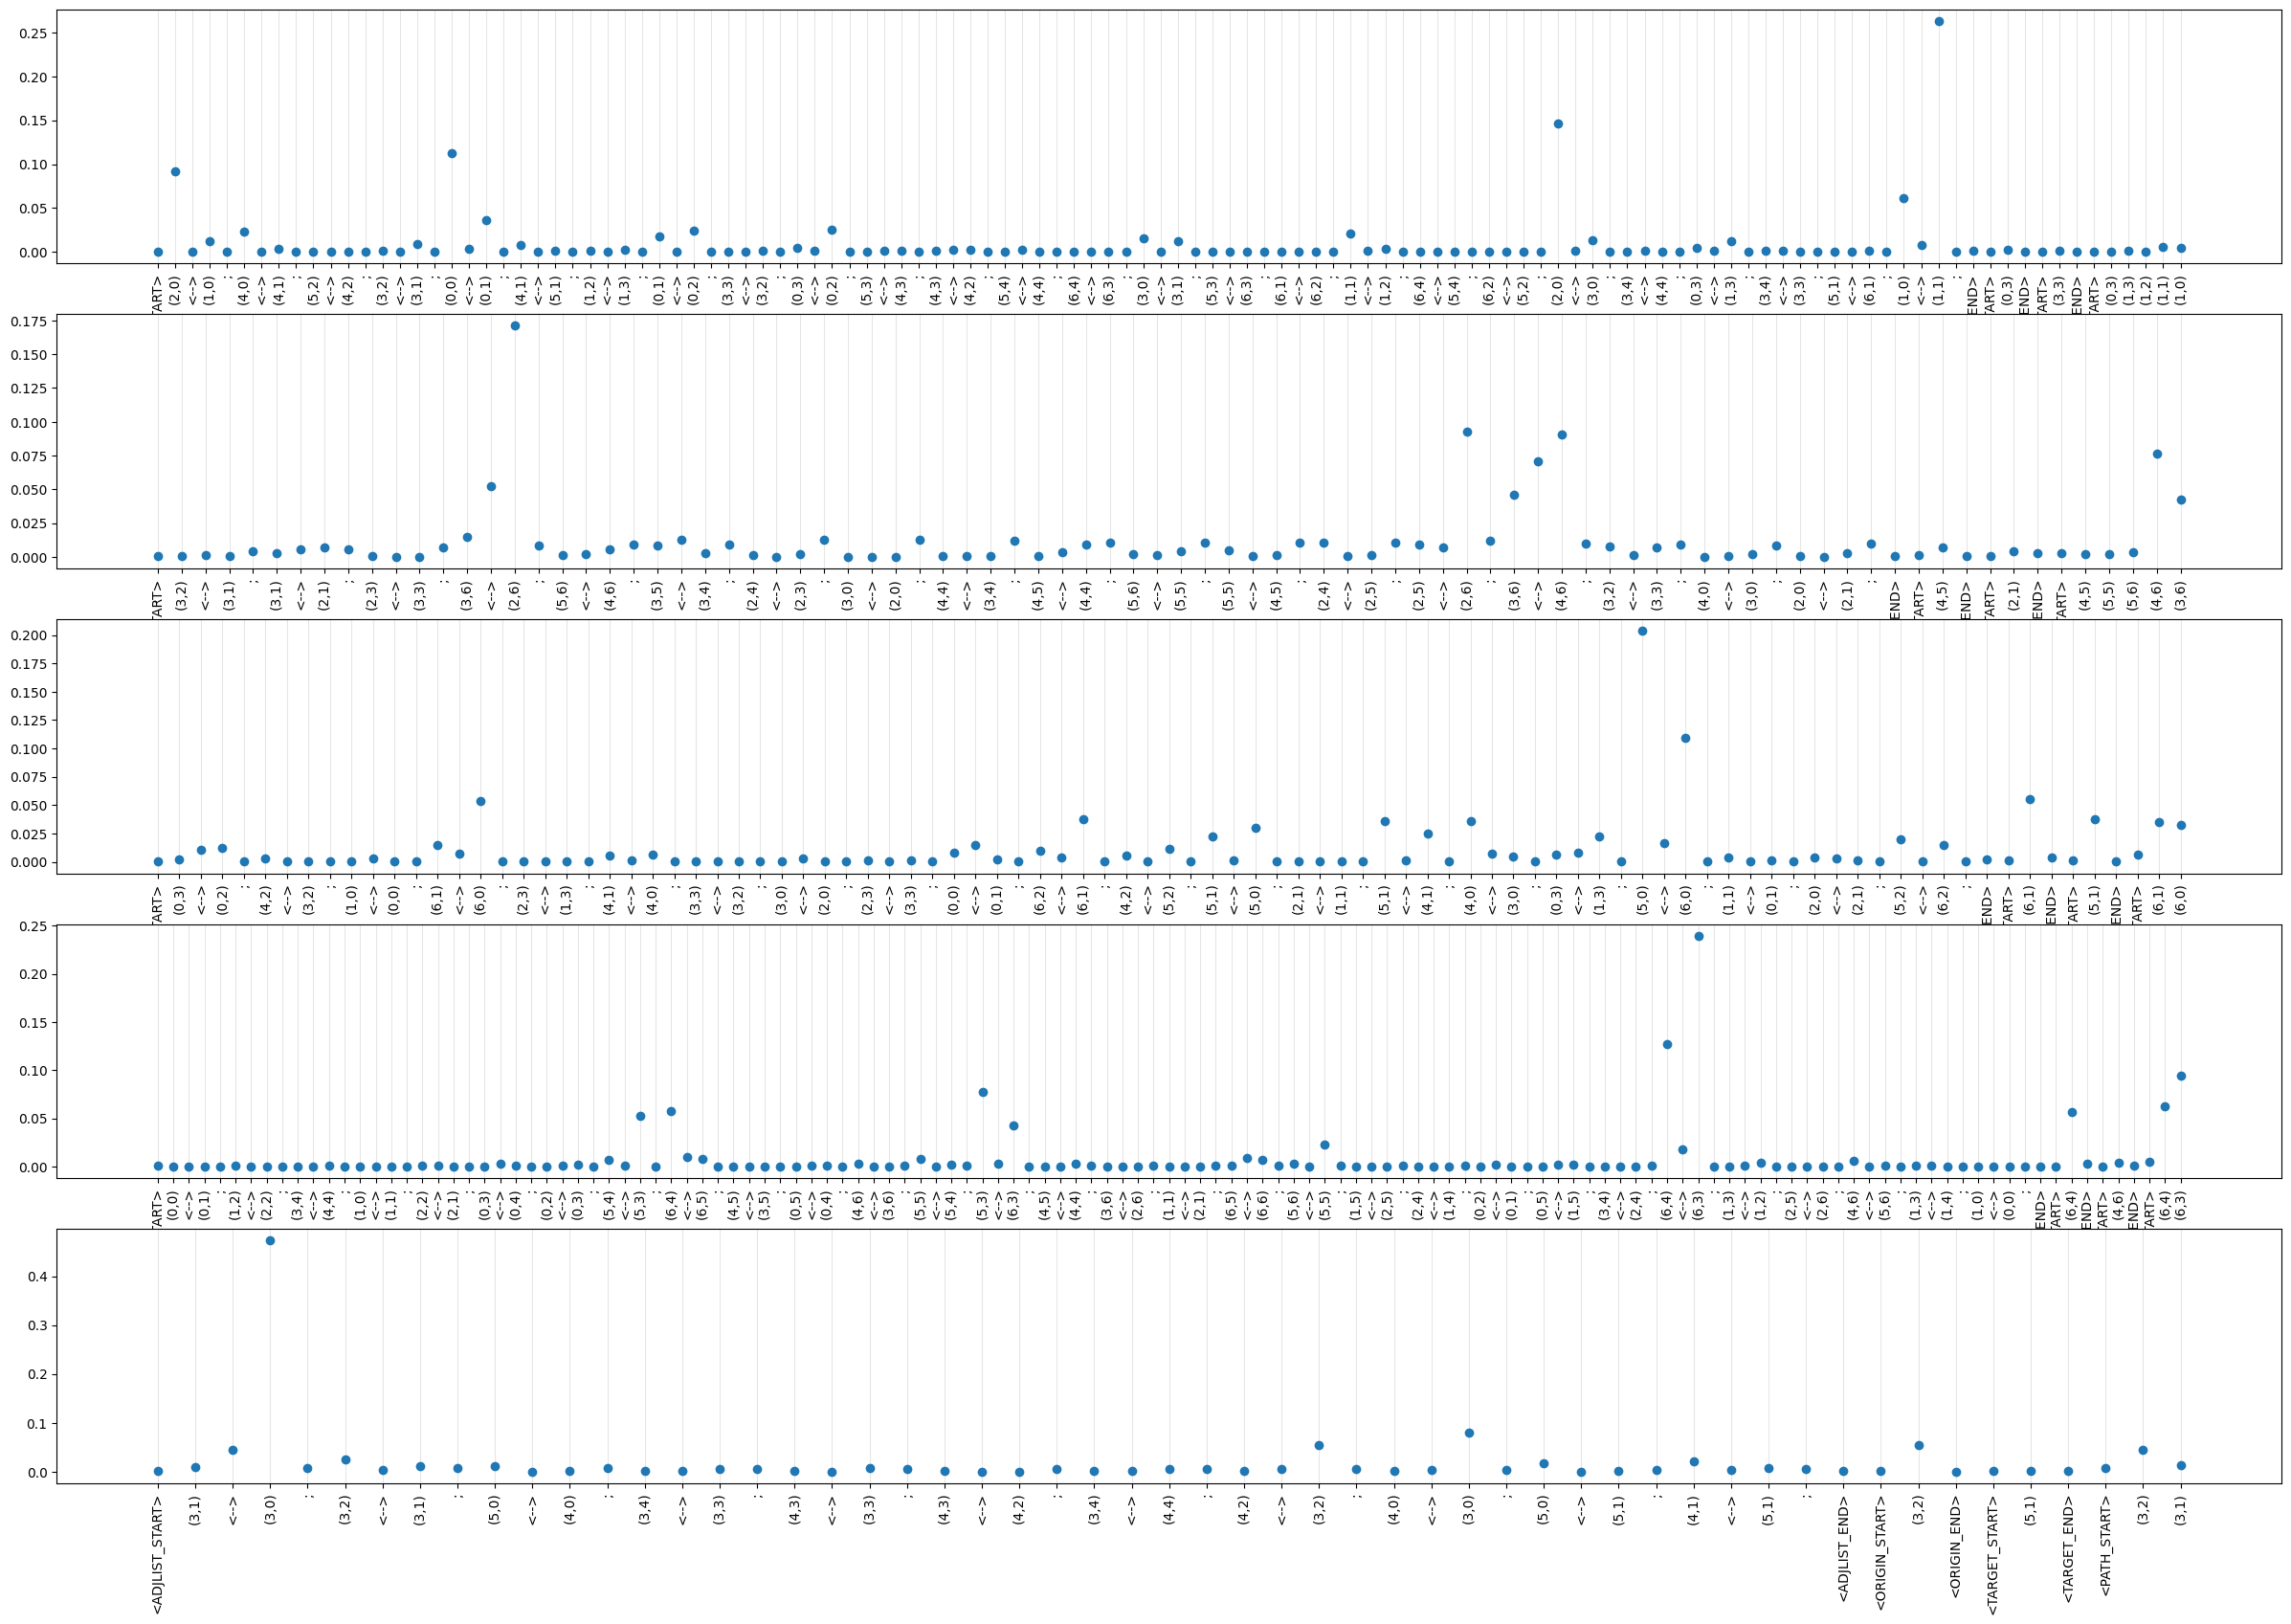

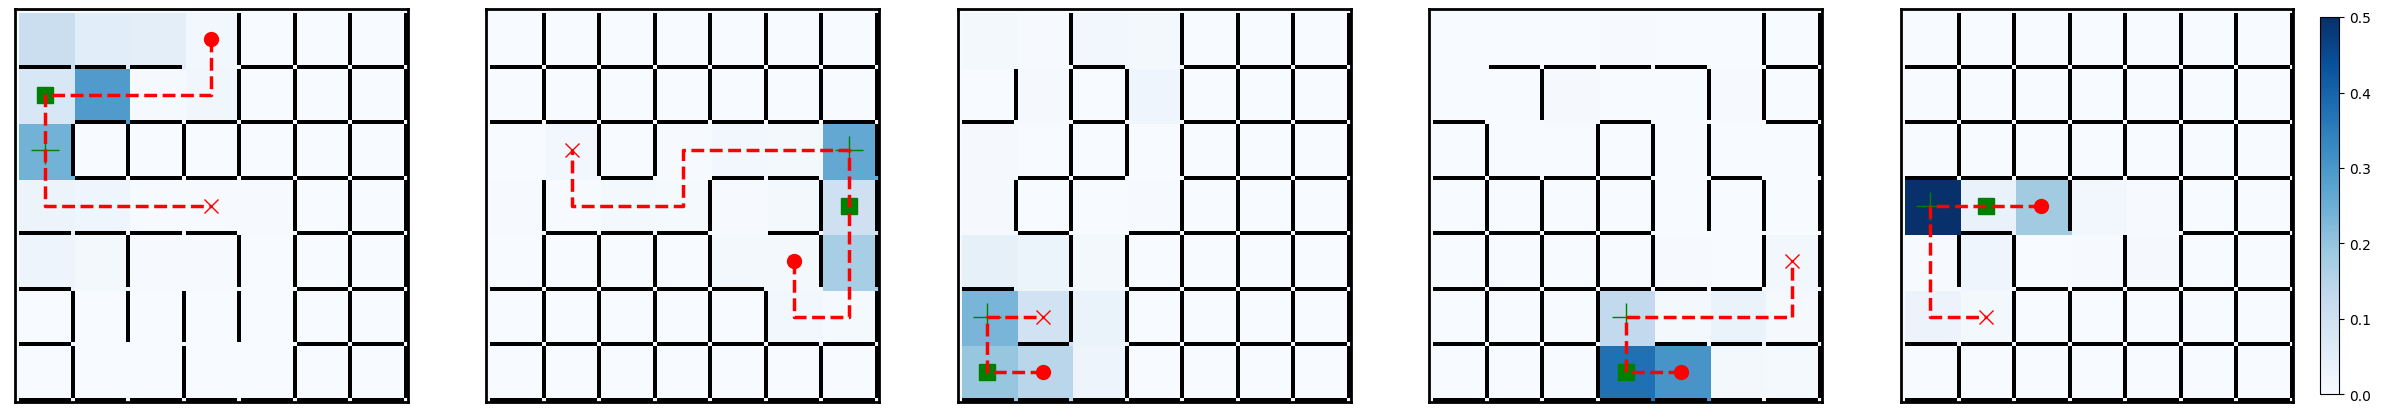

--------------------------------------------------------------------------------
head: layer_5.head_1, score: c = -1.0604424, attn_presoftmax.shape = (200, 201, 201)
<--> (6,1) ; (1,0) <--> (1,1) ; <ADJLIST_END> <ORIGIN_START> (0,3) <ORIGIN_END> <TARGET_START> (3,3) <TARGET_END> <PATH_START> (0,3) (1,3) (1,2) (1,1) (1,0)
0.0  0.0     0.0   0.0  0.0     0.0           0.0            0.0   0.0          0.0            0.0   0.0          0.0          0.0   0.0   0.0   0.1   0.1   
AxesSubplot(0.125,0.11;0.133621x0.77)
self.hide_colorbar = True
<--> (3,0) ; (2,0) <--> (2,1) ; <ADJLIST_END> <ORIGIN_START> (4,5) <ORIGIN_END> <TARGET_START> (2,1) <TARGET_END> <PATH_START> (4,5) (5,5) (5,6) (4,6) (3,6)
0.0  0.0     0.0   0.0  0.0     0.1           0.0            0.0   0.0          0.0            0.0   0.1          0.0          0.0   0.0   0.0   0.0   0.0   
AxesSubplot(0.285345,0.11;0.133621x0.77)
self.hide_colorbar = True
(0,1) ; (2,0) <--> (2,1) ; (5,2) <--> (6,2) ; <ADJLIST_END> <ORIGIN_START

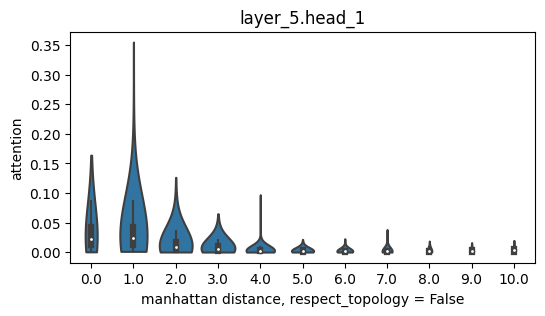

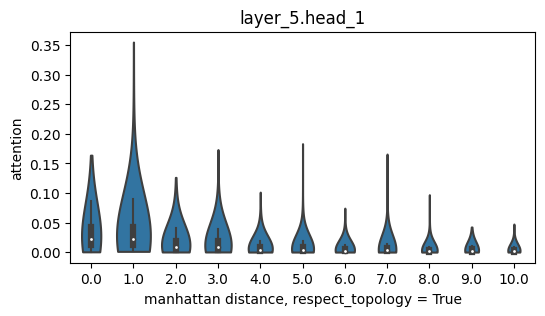

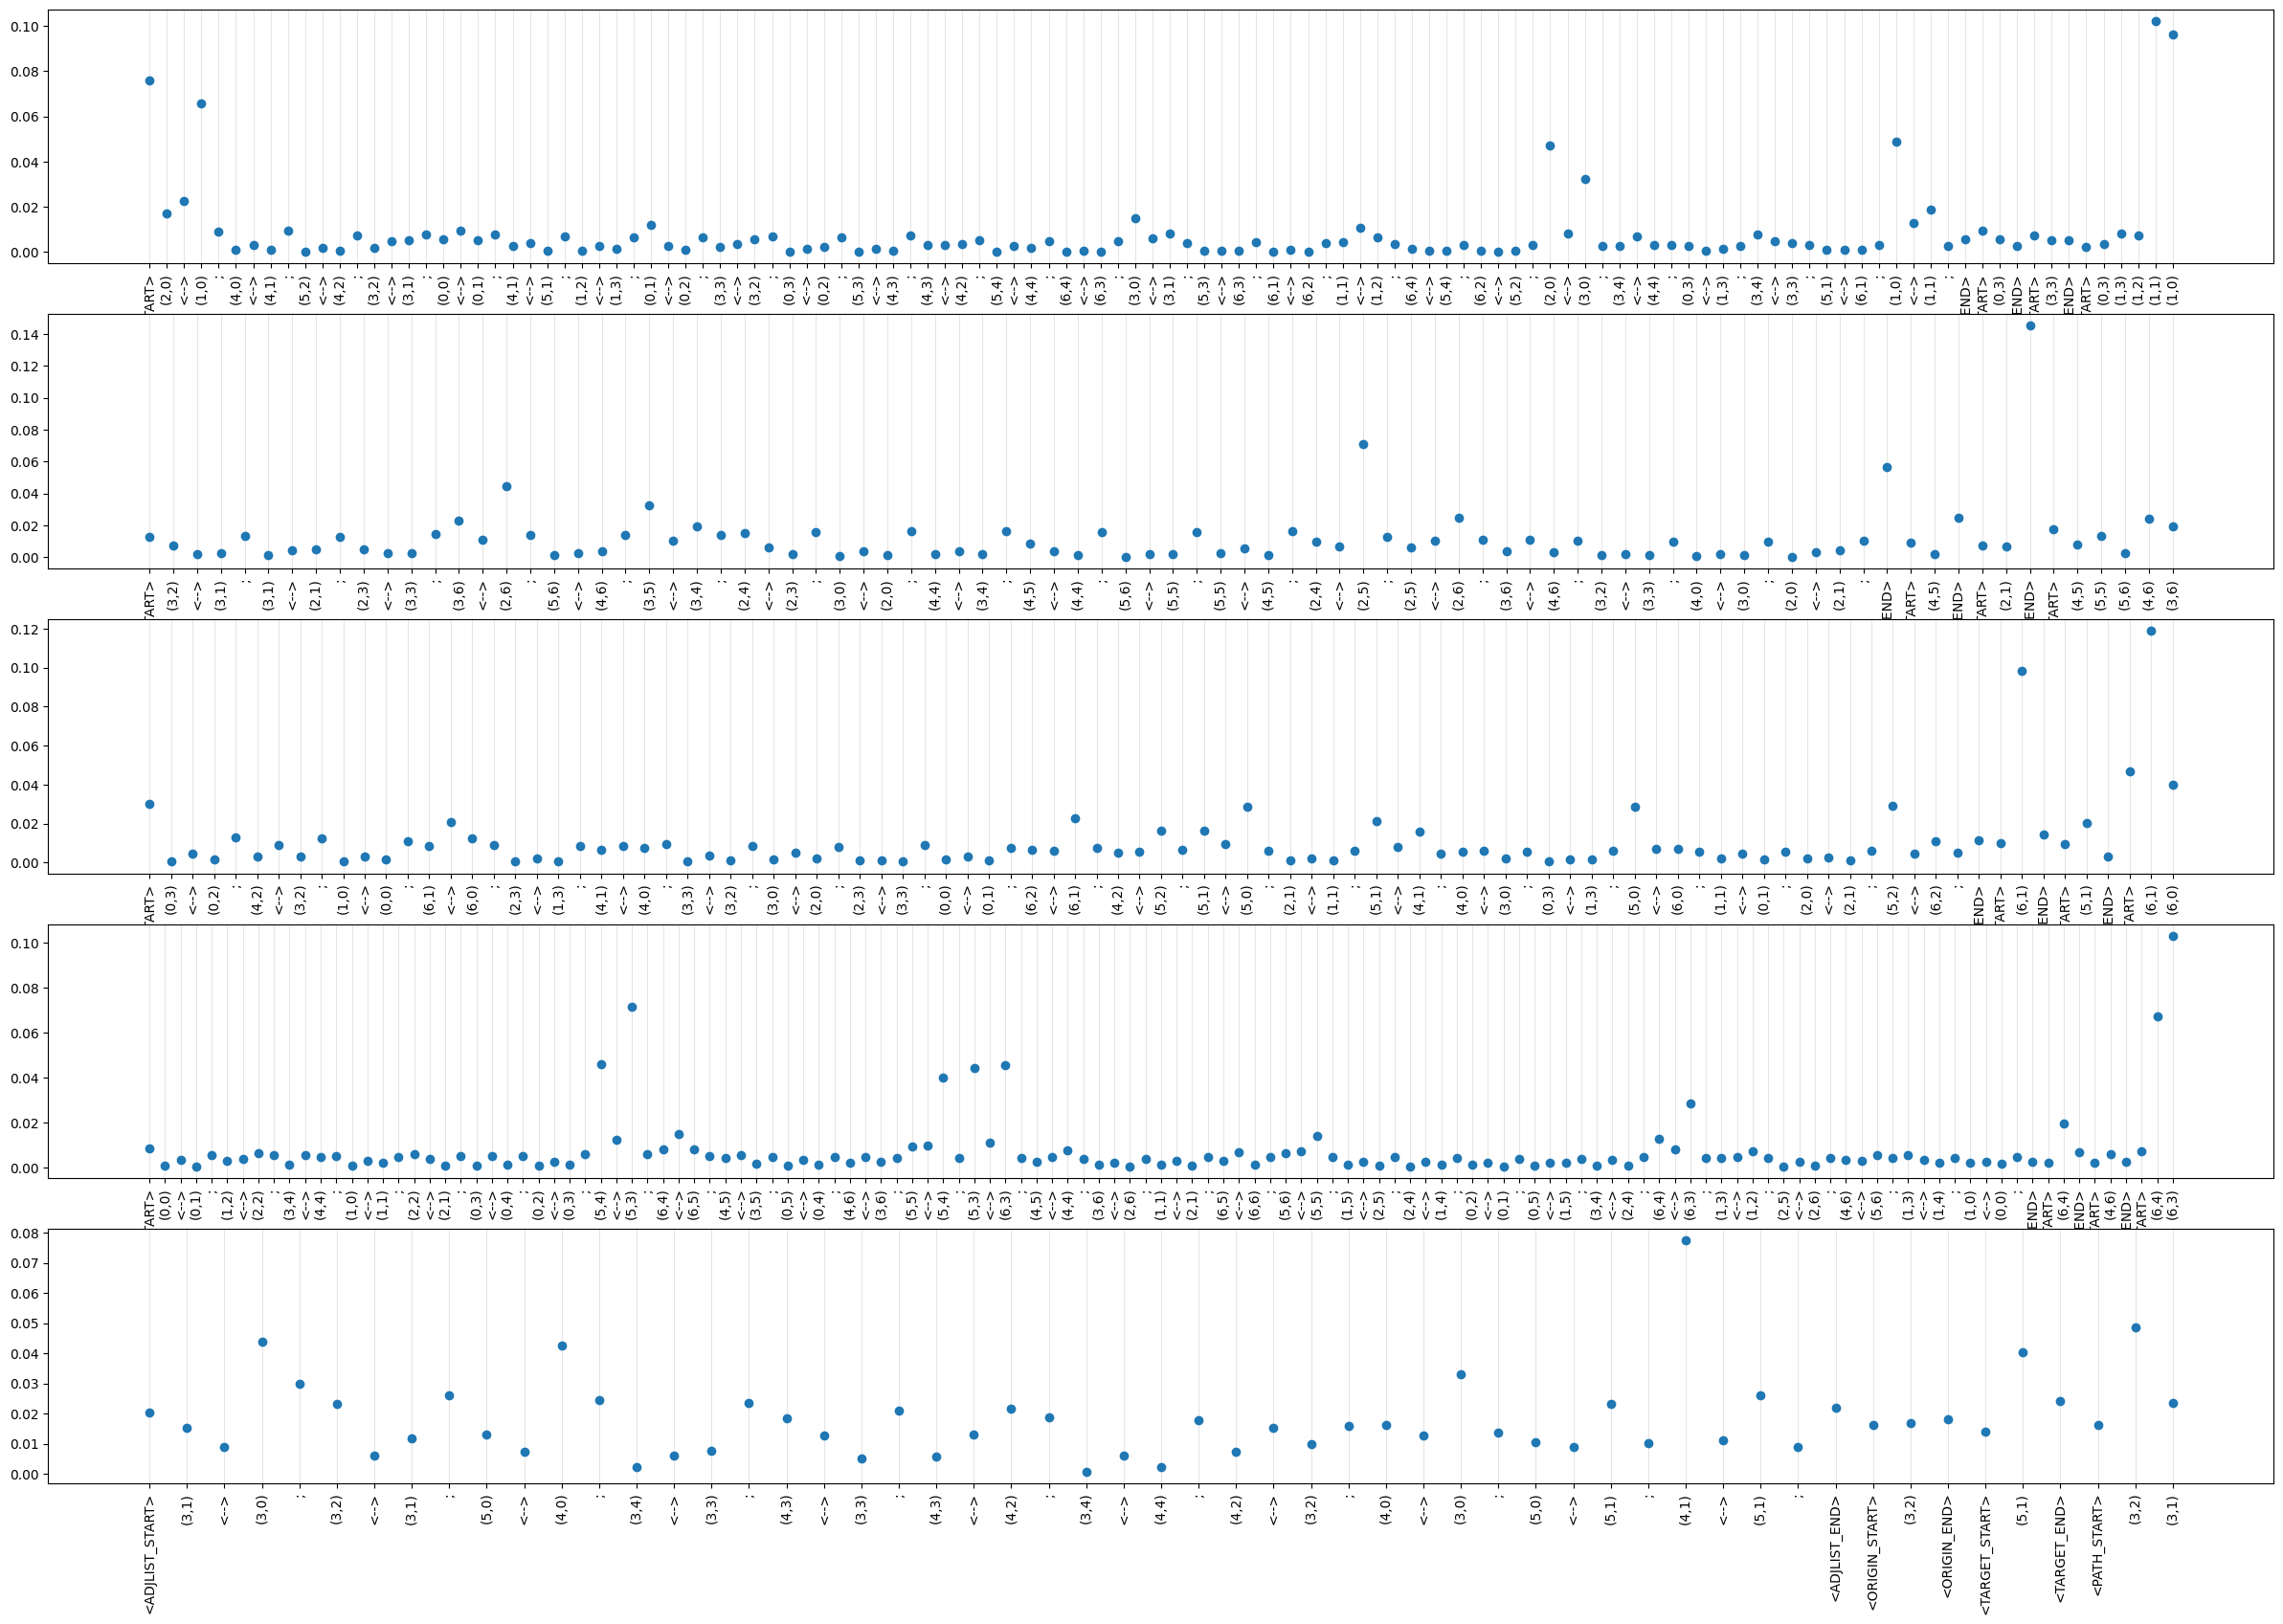

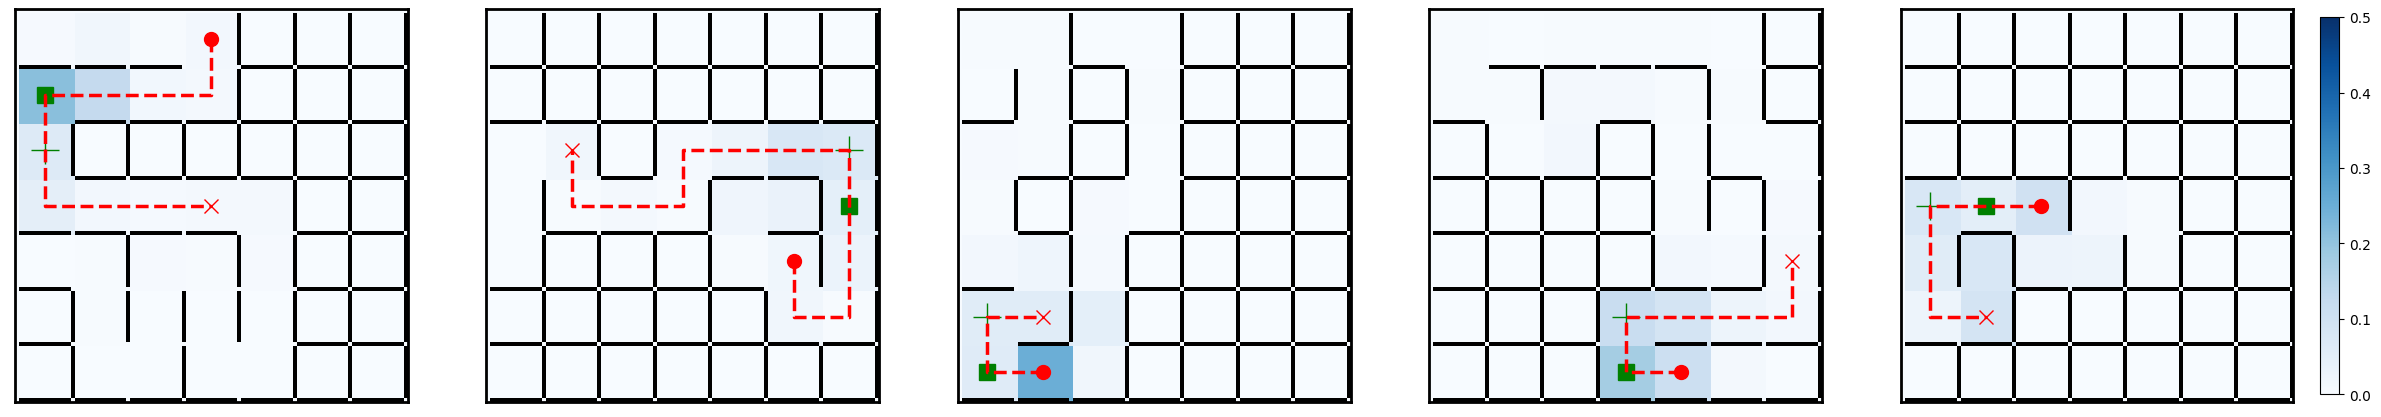

--------------------------------------------------------------------------------
head: layer_5.head_2, score: c = 0.8314017, attn_presoftmax.shape = (200, 201, 201)
<--> (6,1) ; (1,0) <--> (1,1) ; <ADJLIST_END> <ORIGIN_START> (0,3) <ORIGIN_END> <TARGET_START> (3,3) <TARGET_END> <PATH_START> (0,3) (1,3) (1,2) (1,1) (1,0)
0.0  0.0     0.1   0.0  0.1     0.0           0.0            0.0   0.0          0.0            0.0   0.0          0.0          0.0   0.0   0.0   0.1   0.1   
AxesSubplot(0.125,0.11;0.133621x0.77)
self.hide_colorbar = True
<--> (3,0) ; (2,0) <--> (2,1) ; <ADJLIST_END> <ORIGIN_START> (4,5) <ORIGIN_END> <TARGET_START> (2,1) <TARGET_END> <PATH_START> (4,5) (5,5) (5,6) (4,6) (3,6)
0.0  0.0     0.0   0.0  0.0     0.0           0.0            0.0   0.0          0.0            0.0   0.0          0.0          0.0   0.0   0.0   0.0   0.0   
AxesSubplot(0.285345,0.11;0.133621x0.77)
self.hide_colorbar = True
(0,1) ; (2,0) <--> (2,1) ; (5,2) <--> (6,2) ; <ADJLIST_END> <ORIGIN_START>

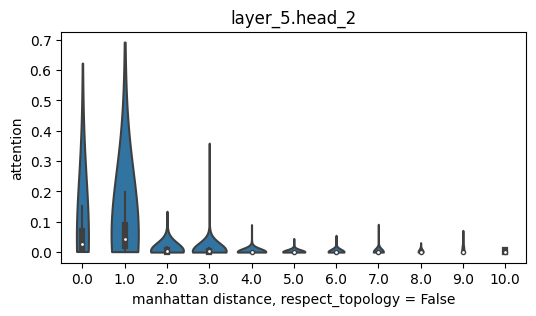

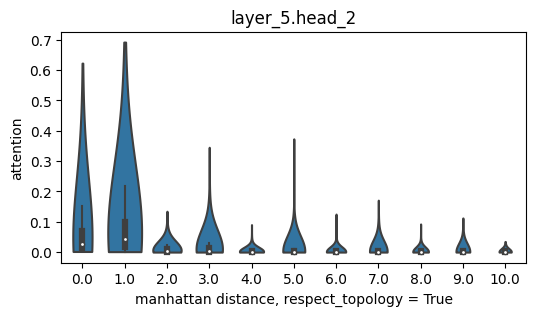

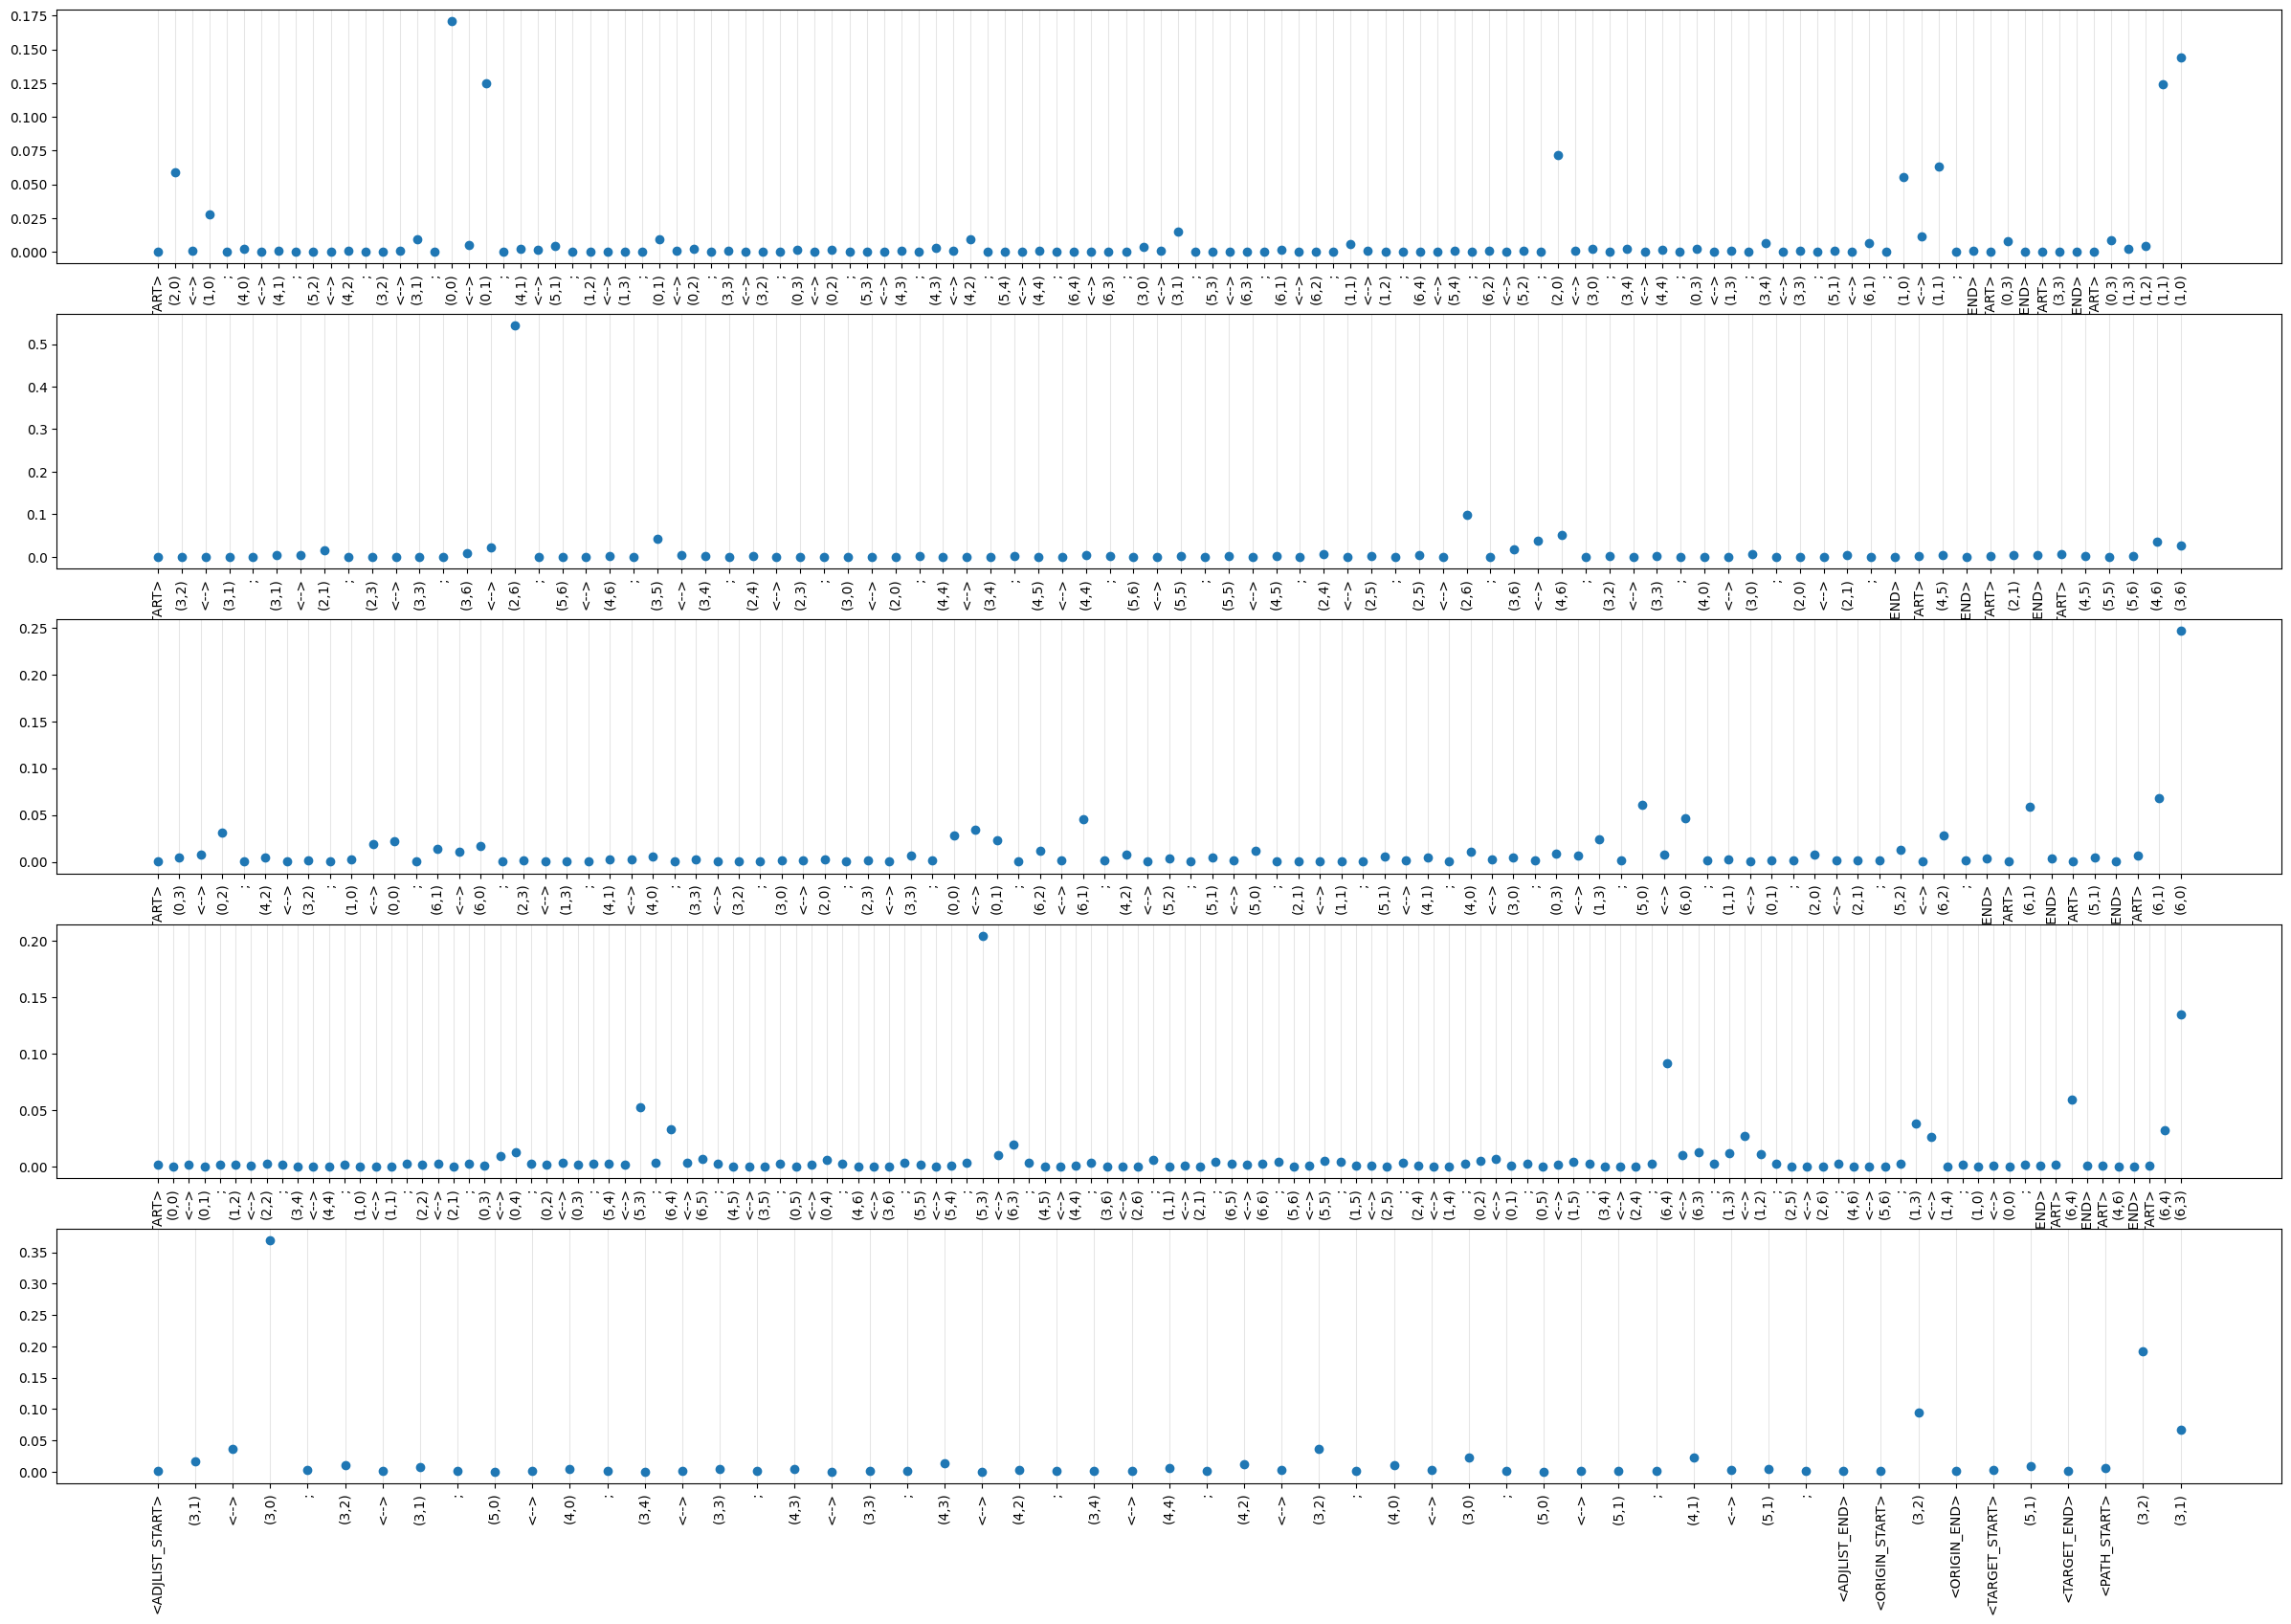

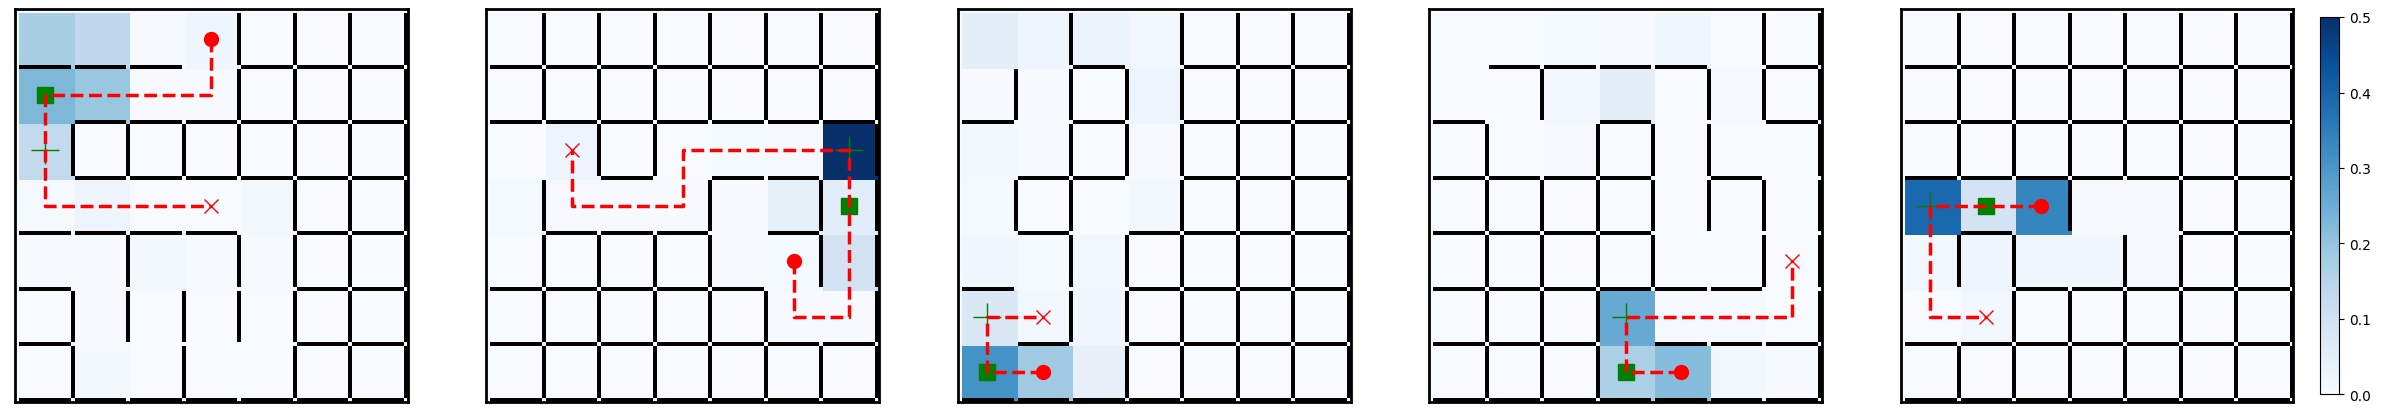

--------------------------------------------------------------------------------
head: layer_4.head_3, score: c = 0.46919096, attn_presoftmax.shape = (200, 201, 201)
<--> (6,1) ; (1,0) <--> (1,1) ; <ADJLIST_END> <ORIGIN_START> (0,3) <ORIGIN_END> <TARGET_START> (3,3) <TARGET_END> <PATH_START> (0,3) (1,3) (1,2) (1,1) (1,0)
0.0  0.0     0.2   0.0  0.1     0.0           0.0            0.0   0.0          0.0            0.0   0.0          0.0          0.0   0.0   0.0   0.0   0.0   
AxesSubplot(0.125,0.11;0.133621x0.77)
self.hide_colorbar = True
<--> (3,0) ; (2,0) <--> (2,1) ; <ADJLIST_END> <ORIGIN_START> (4,5) <ORIGIN_END> <TARGET_START> (2,1) <TARGET_END> <PATH_START> (4,5) (5,5) (5,6) (4,6) (3,6)
0.0  0.0     0.0   0.0  0.0     0.0           0.0            0.0   0.0          0.0            0.1   0.0          0.0          0.0   0.0   0.0   0.0   0.0   
AxesSubplot(0.285345,0.11;0.133621x0.77)
self.hide_colorbar = True
(0,1) ; (2,0) <--> (2,1) ; (5,2) <--> (6,2) ; <ADJLIST_END> <ORIGIN_START

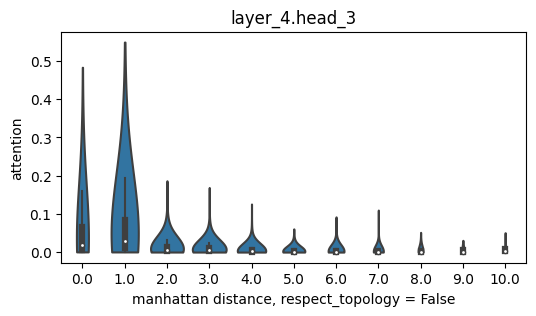

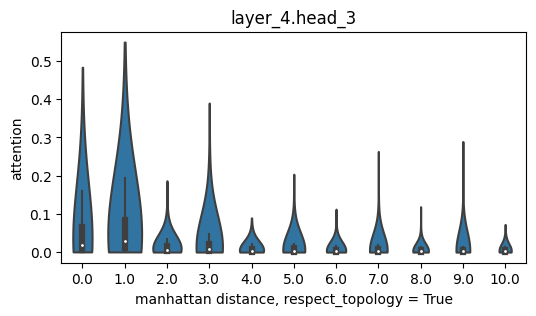

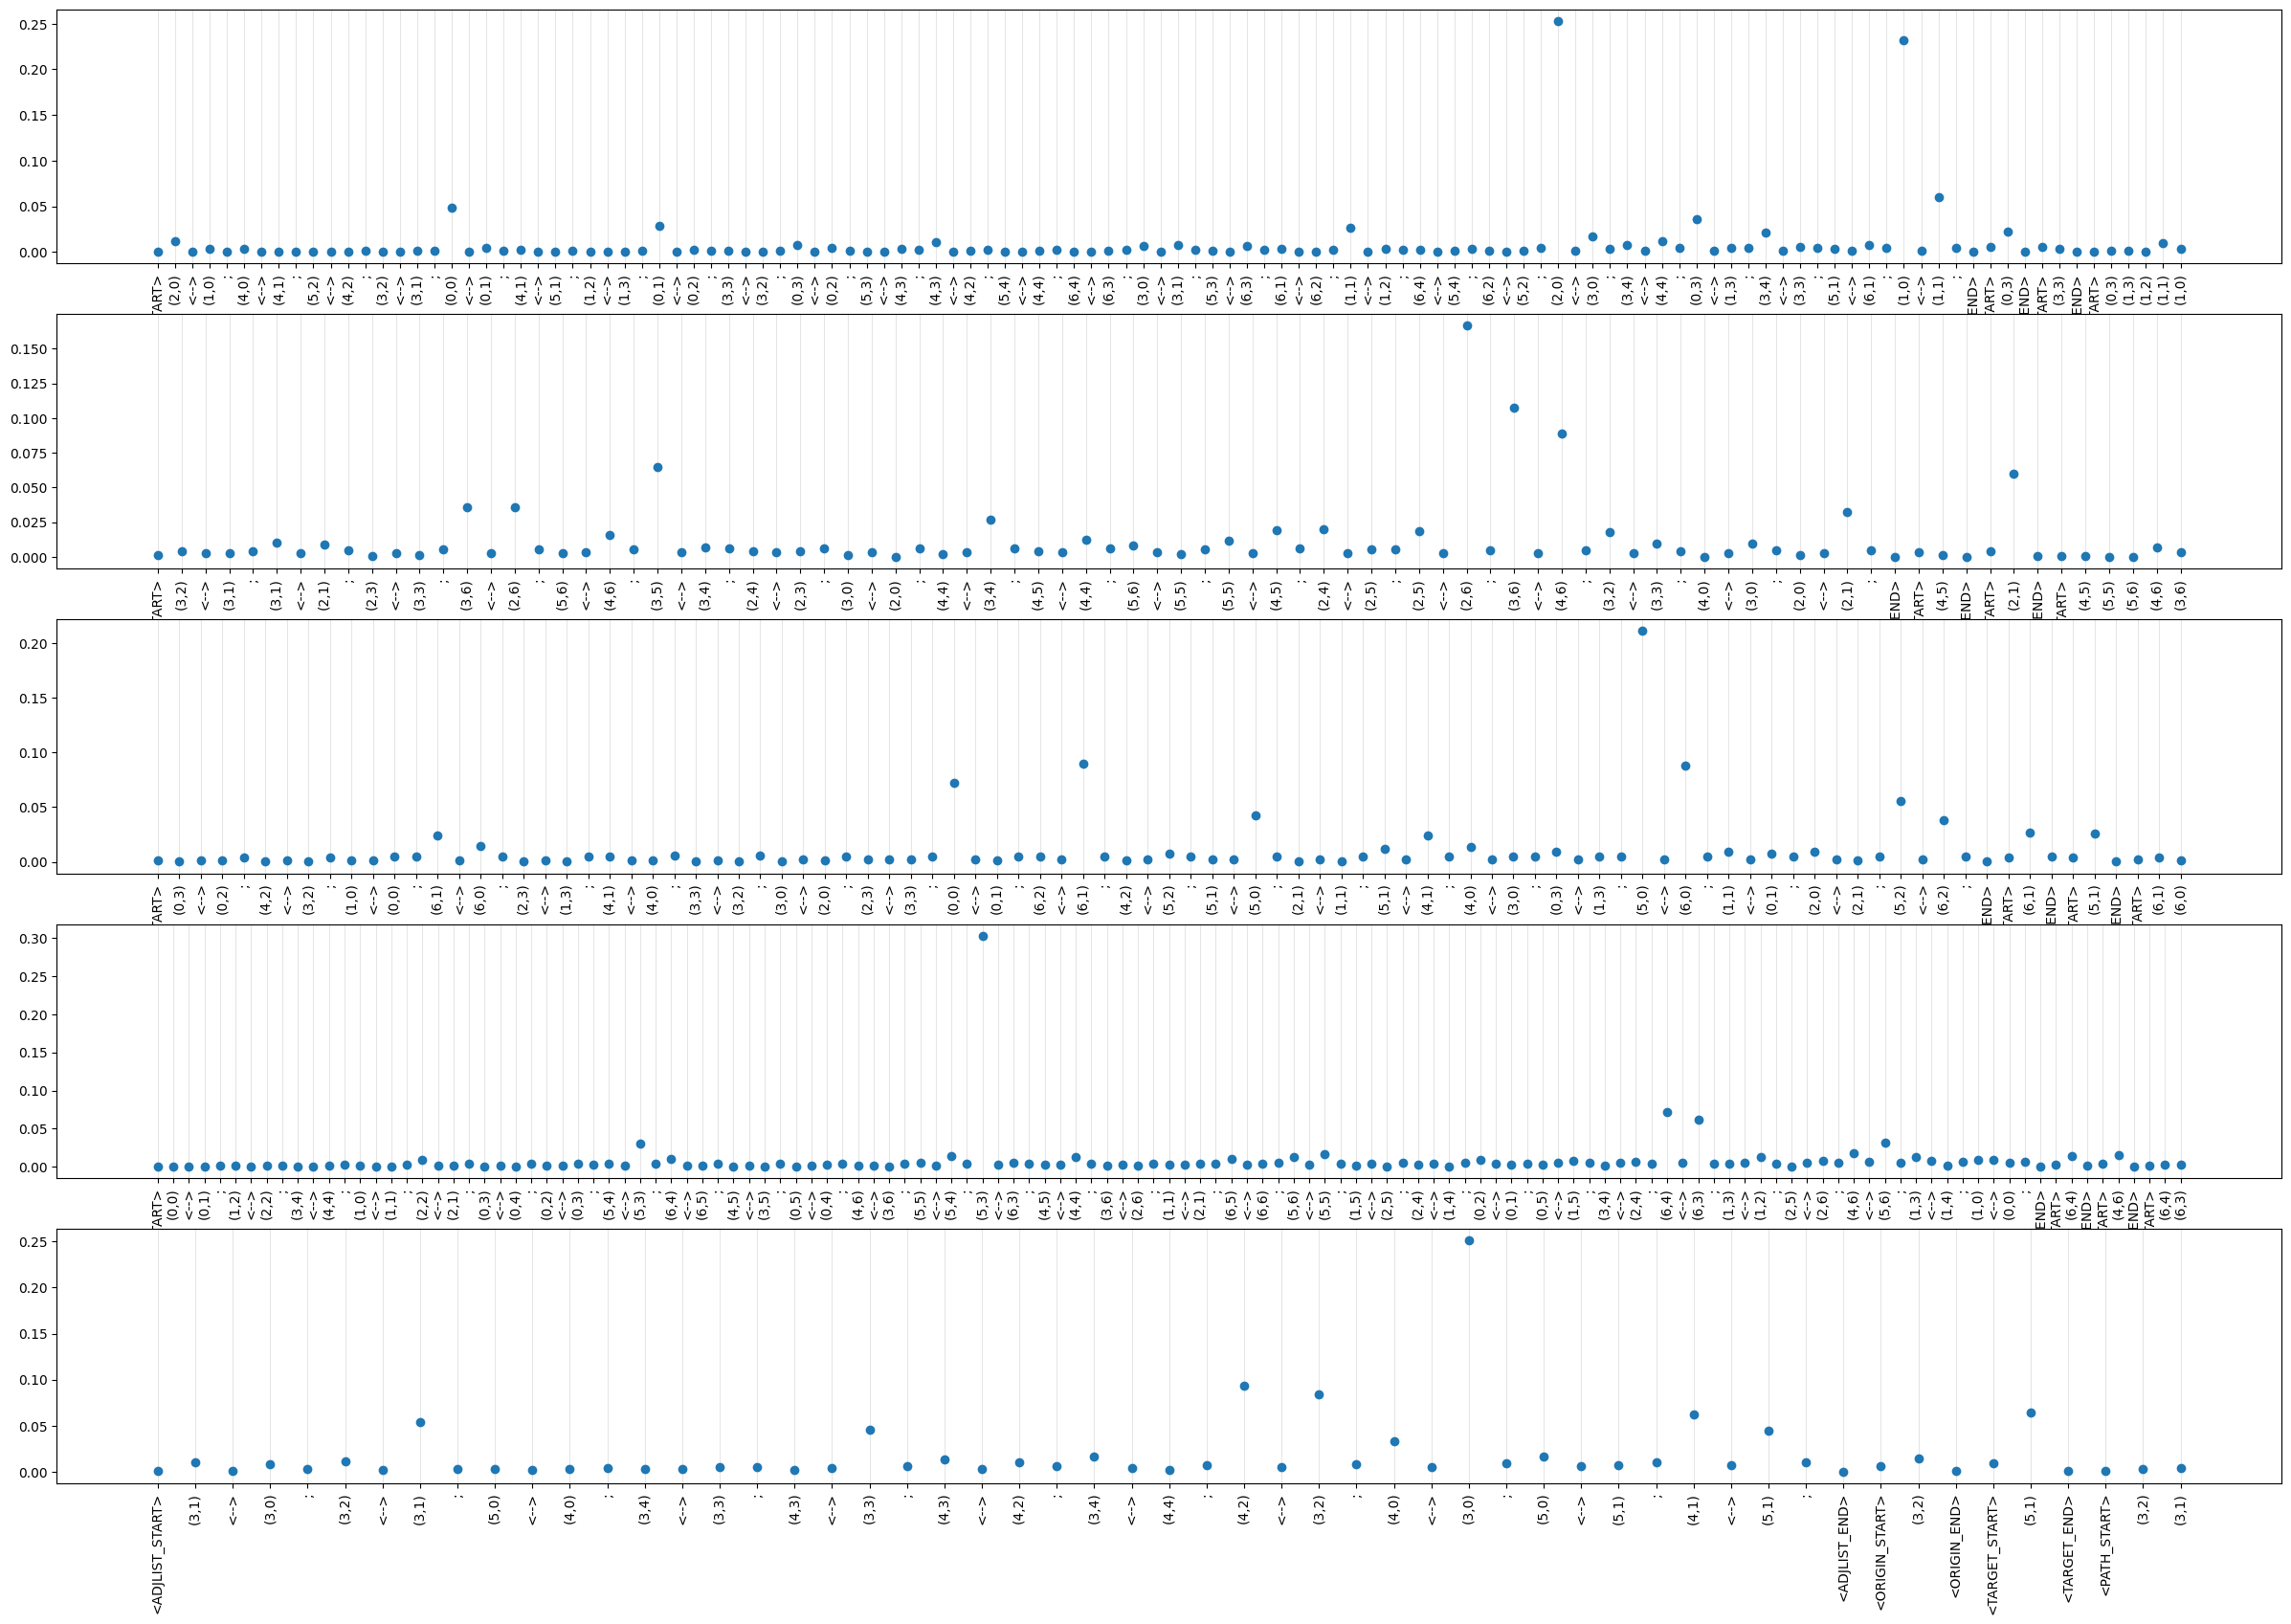

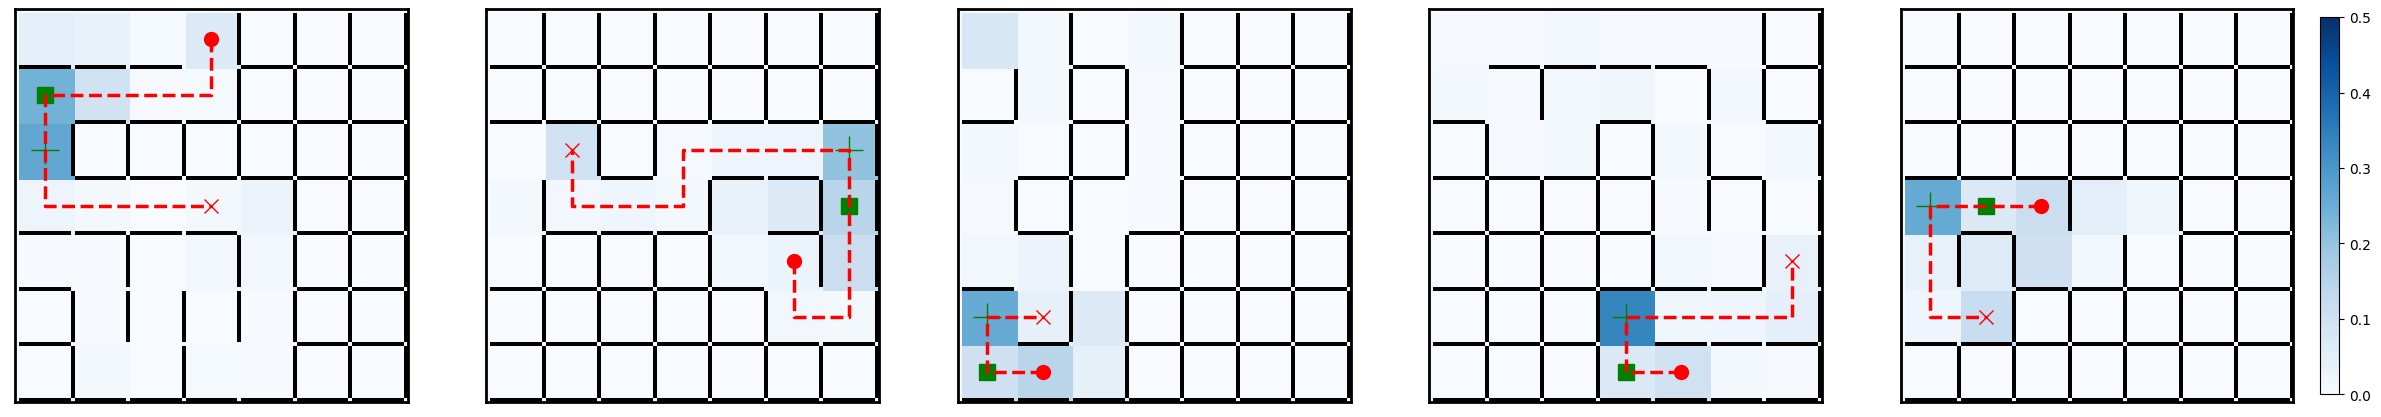

--------------------------------------------------------------------------------
head: layer_4.head_1, score: c = 0.3916713, attn_presoftmax.shape = (200, 201, 201)
<--> (6,1) ; (1,0) <--> (1,1) ; <ADJLIST_END> <ORIGIN_START> (0,3) <ORIGIN_END> <TARGET_START> (3,3) <TARGET_END> <PATH_START> (0,3) (1,3) (1,2) (1,1) (1,0)
0.0  0.0     0.1   0.0  0.0     0.0           0.0            0.0   0.0          0.0            0.0   0.0          0.0          0.0   0.0   0.0   0.0   0.0   
AxesSubplot(0.125,0.11;0.133621x0.77)
self.hide_colorbar = True
<--> (3,0) ; (2,0) <--> (2,1) ; <ADJLIST_END> <ORIGIN_START> (4,5) <ORIGIN_END> <TARGET_START> (2,1) <TARGET_END> <PATH_START> (4,5) (5,5) (5,6) (4,6) (3,6)
0.0  0.0     0.0   0.0  0.0     0.0           0.0            0.0   0.0          0.0            0.0   0.0          0.0          0.0   0.0   0.0   0.0   0.0   
AxesSubplot(0.285345,0.11;0.133621x0.77)
self.hide_colorbar = True
(0,1) ; (2,0) <--> (2,1) ; (5,2) <--> (6,2) ; <ADJLIST_END> <ORIGIN_START>

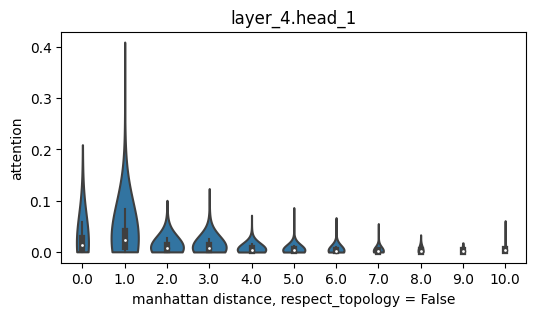

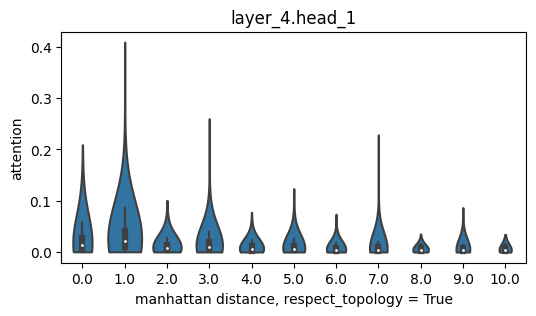

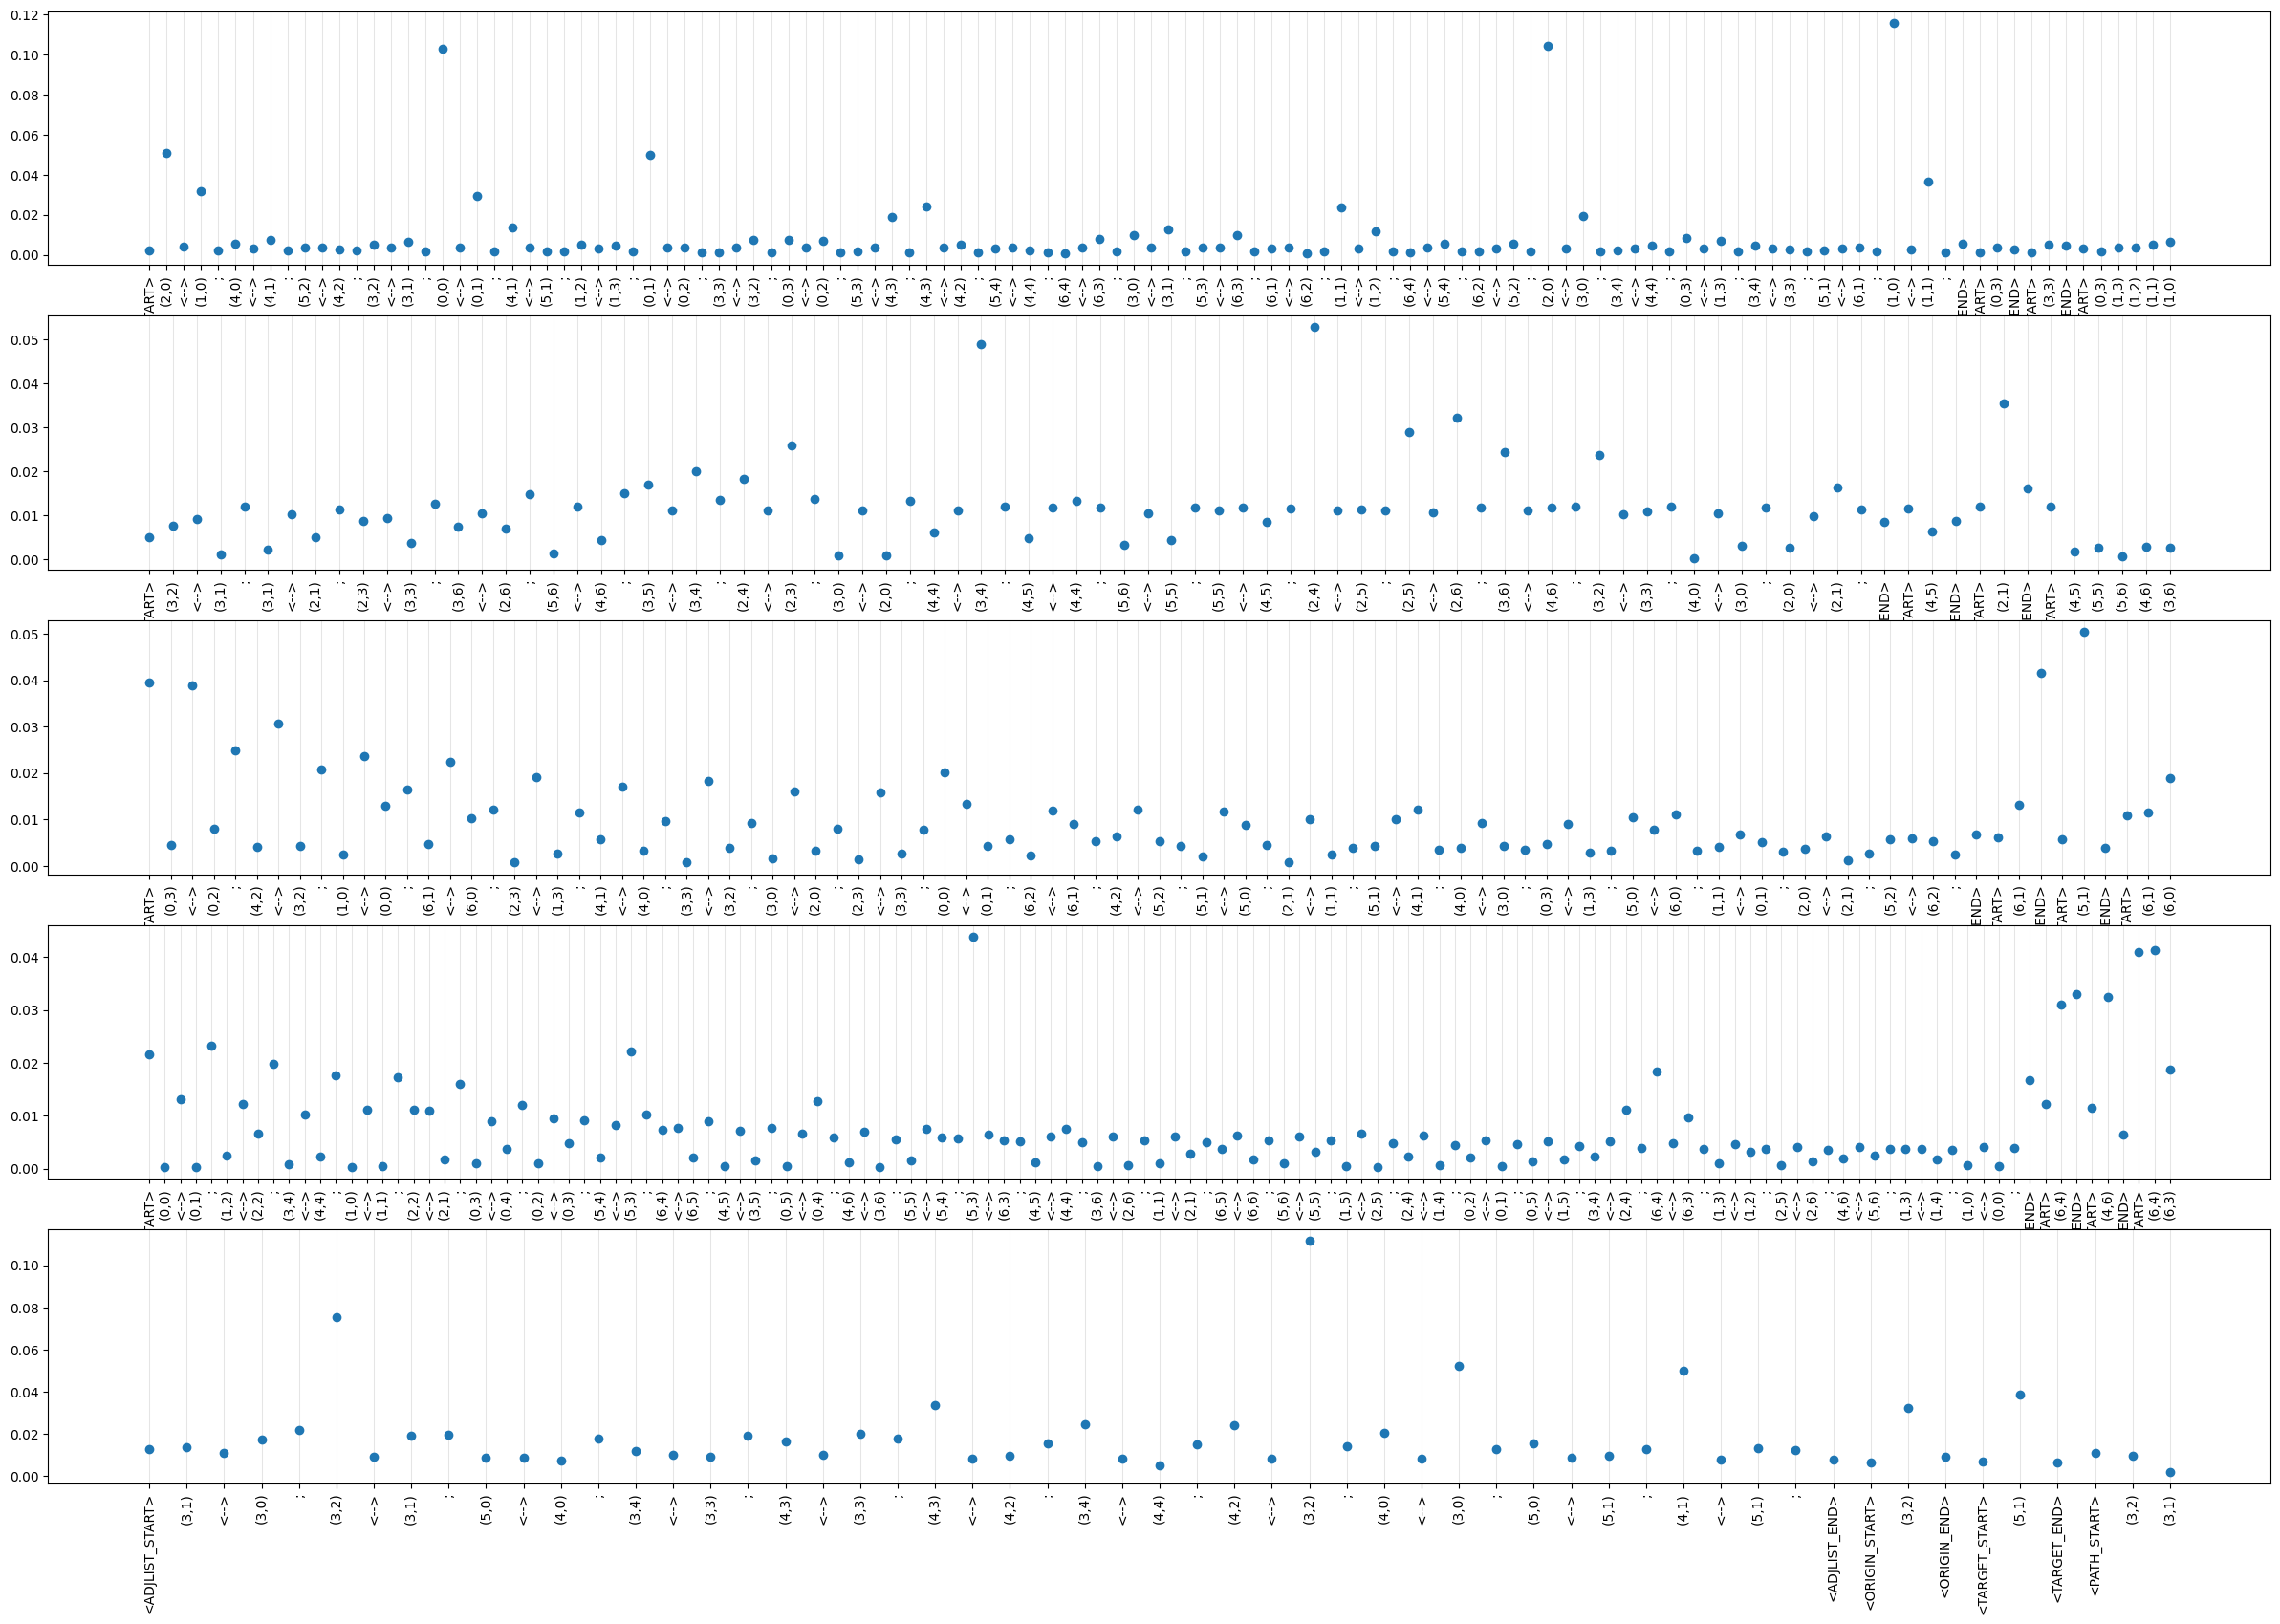

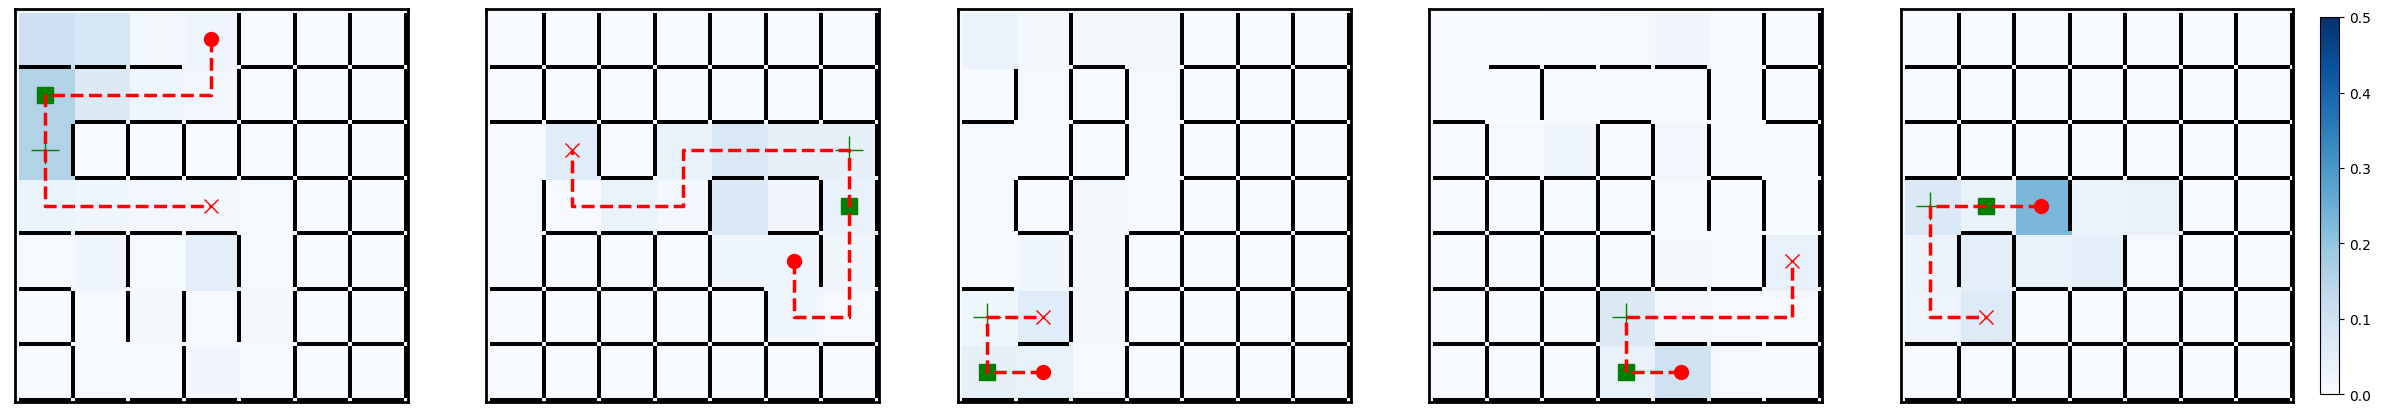

--------------------------------------------------------------------------------
head: layer_4.head_0, score: c = -0.3201226, attn_presoftmax.shape = (200, 201, 201)
<--> (6,1) ; (1,0) <--> (1,1) ; <ADJLIST_END> <ORIGIN_START> (0,3) <ORIGIN_END> <TARGET_START> (3,3) <TARGET_END> <PATH_START> (0,3) (1,3) (1,2) (1,1) (1,0)
0.0  0.0     0.0   0.0  0.0     0.0           0.1            0.0   0.0          0.1            0.0   0.0          0.1          0.1   0.1   0.0   0.2   0.3   
AxesSubplot(0.125,0.11;0.133621x0.77)
self.hide_colorbar = True
<--> (3,0) ; (2,0) <--> (2,1) ; <ADJLIST_END> <ORIGIN_START> (4,5) <ORIGIN_END> <TARGET_START> (2,1) <TARGET_END> <PATH_START> (4,5) (5,5) (5,6) (4,6) (3,6)
0.0  0.0     0.0   0.0  0.0     0.0           0.0            0.0   0.0          0.0            0.0   0.0          0.0          0.1   0.0   0.0   0.3   0.3   
AxesSubplot(0.285345,0.11;0.133621x0.77)
self.hide_colorbar = True
(0,1) ; (2,0) <--> (2,1) ; (5,2) <--> (6,2) ; <ADJLIST_END> <ORIGIN_START

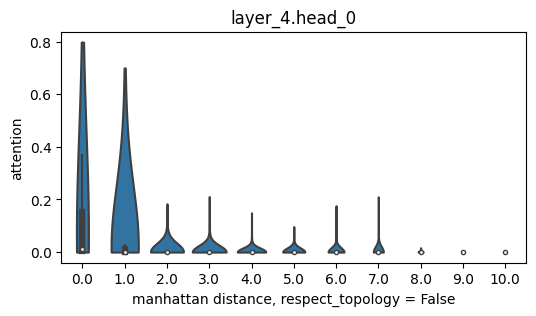

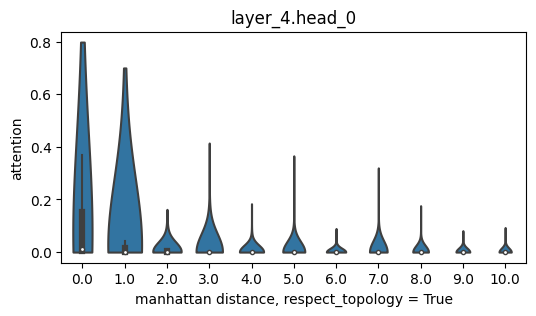

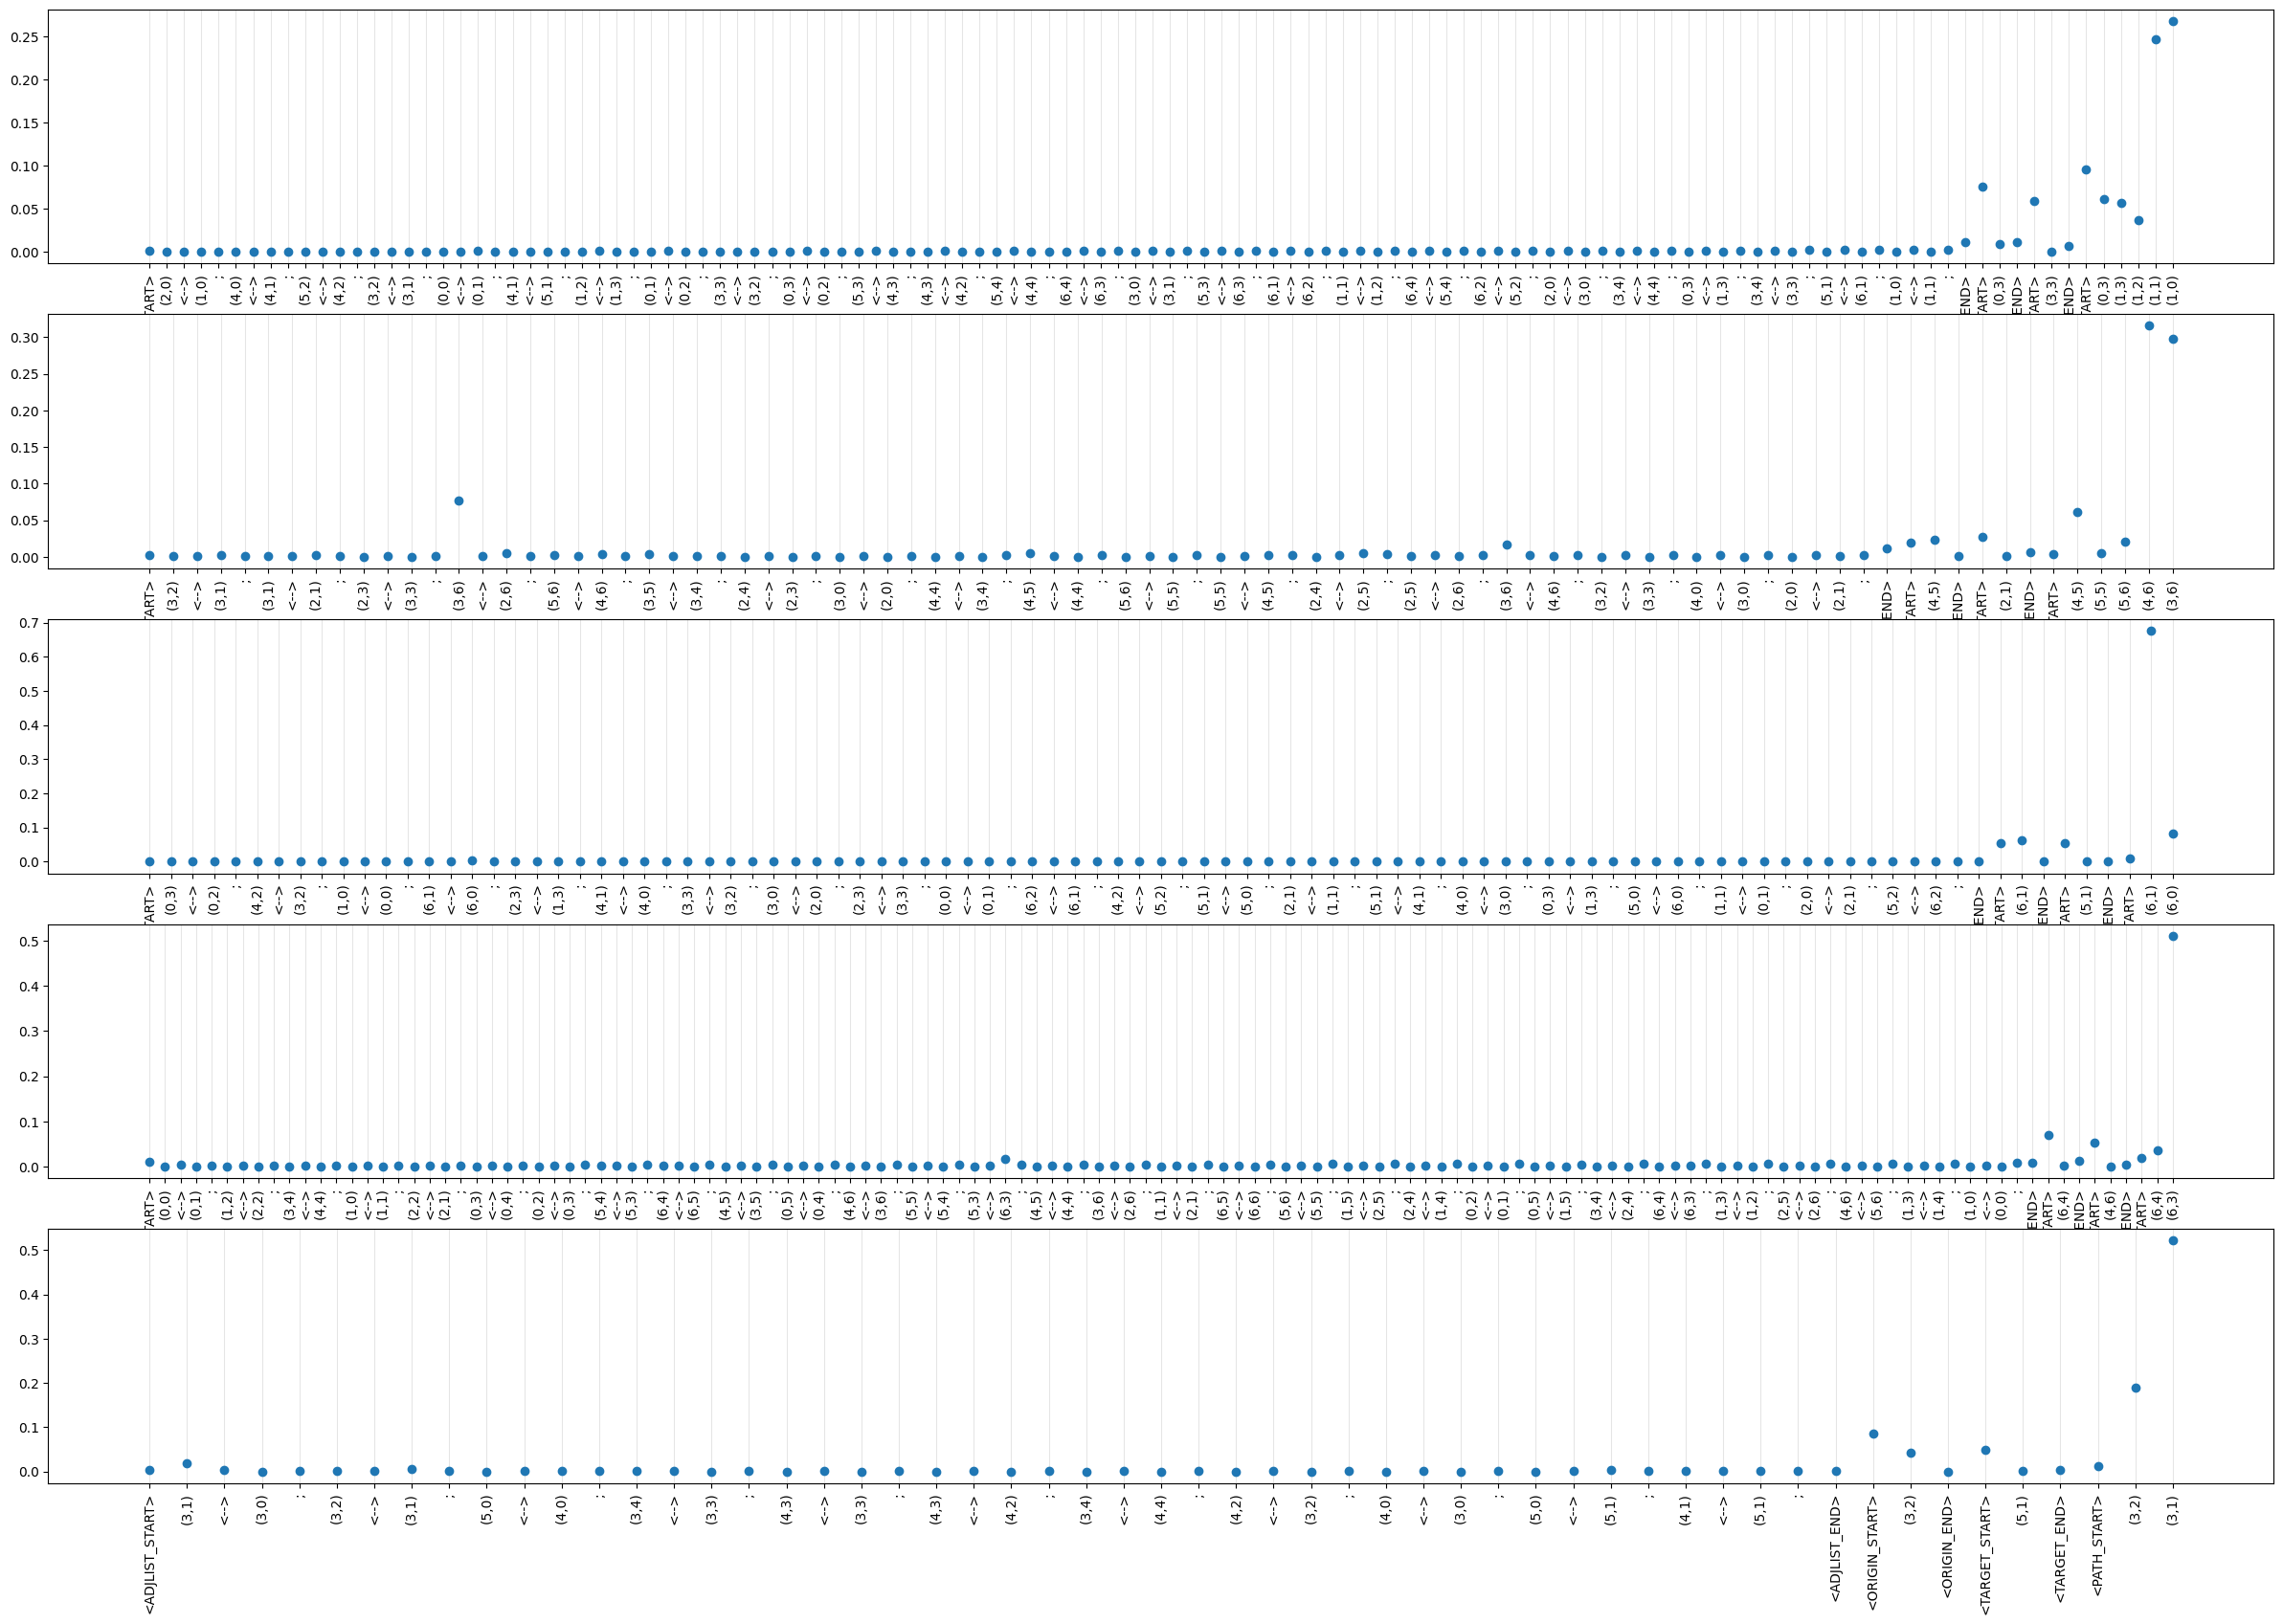

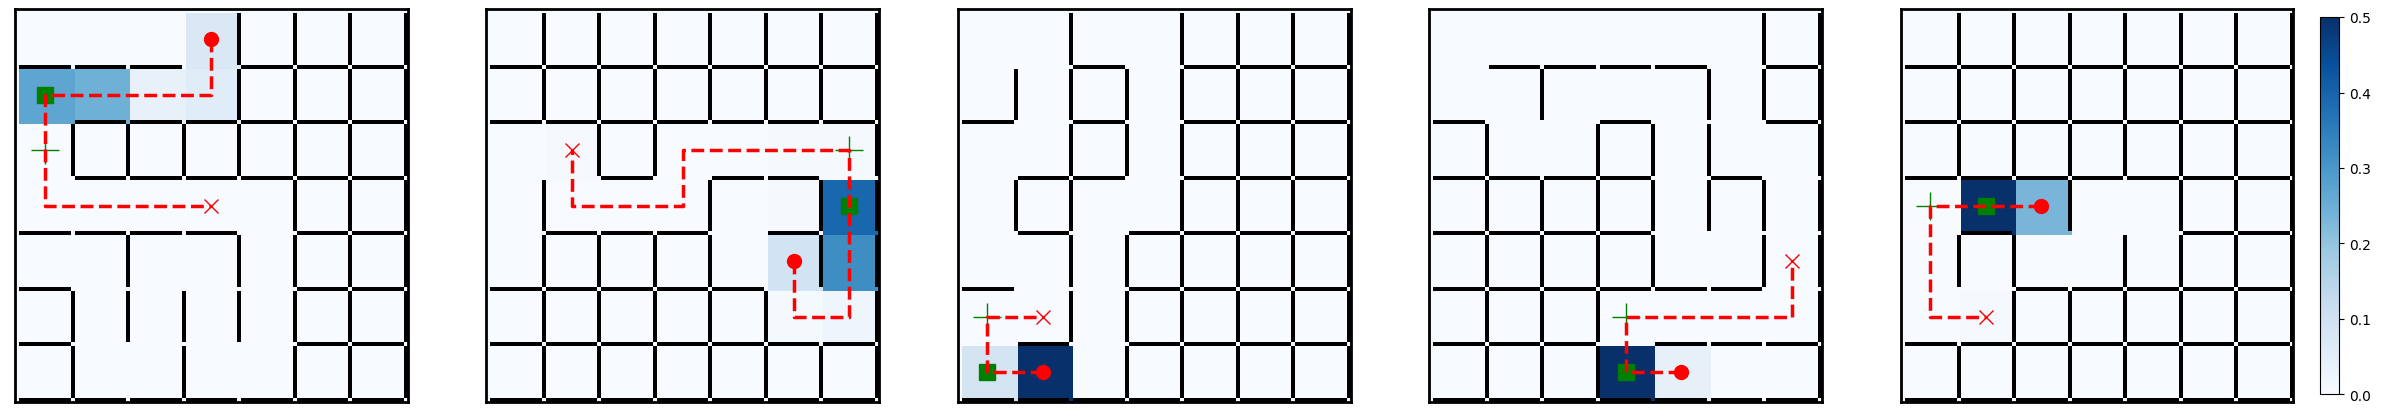

--------------------------------------------------------------------------------
head: layer_1.head_2, score: c = 0.26551077, attn_presoftmax.shape = (200, 201, 201)
<--> (6,1) ; (1,0) <--> (1,1) ; <ADJLIST_END> <ORIGIN_START> (0,3) <ORIGIN_END> <TARGET_START> (3,3) <TARGET_END> <PATH_START> (0,3) (1,3) (1,2) (1,1) (1,0)
0.0  0.0     0.0   0.0  0.0     0.0           0.0            0.0   0.0          0.0            0.0   1.0          0.0          0.0   0.0   0.0   0.0   0.0   
AxesSubplot(0.125,0.11;0.133621x0.77)
self.hide_colorbar = True
<--> (3,0) ; (2,0) <--> (2,1) ; <ADJLIST_END> <ORIGIN_START> (4,5) <ORIGIN_END> <TARGET_START> (2,1) <TARGET_END> <PATH_START> (4,5) (5,5) (5,6) (4,6) (3,6)
0.0  0.0     0.0   0.0  0.0     0.0           0.0            0.0   0.0          0.0            0.0   1.0          0.0          0.0   0.0   0.0   0.0   0.0   
AxesSubplot(0.285345,0.11;0.133621x0.77)
self.hide_colorbar = True
(0,1) ; (2,0) <--> (2,1) ; (5,2) <--> (6,2) ; <ADJLIST_END> <ORIGIN_START

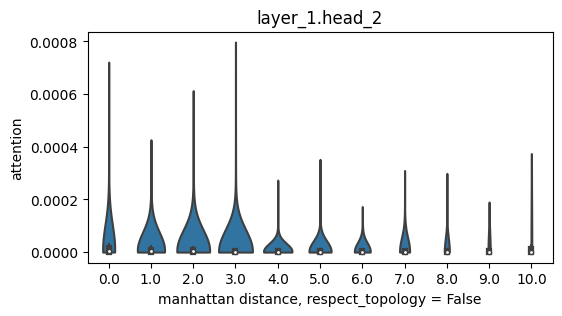

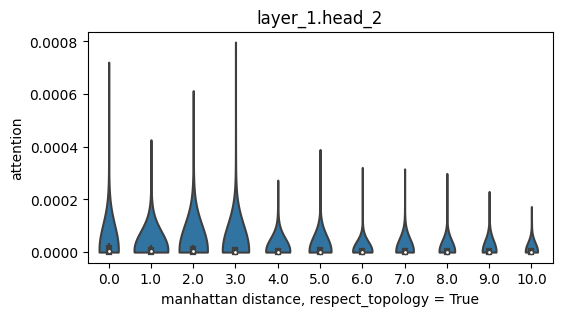

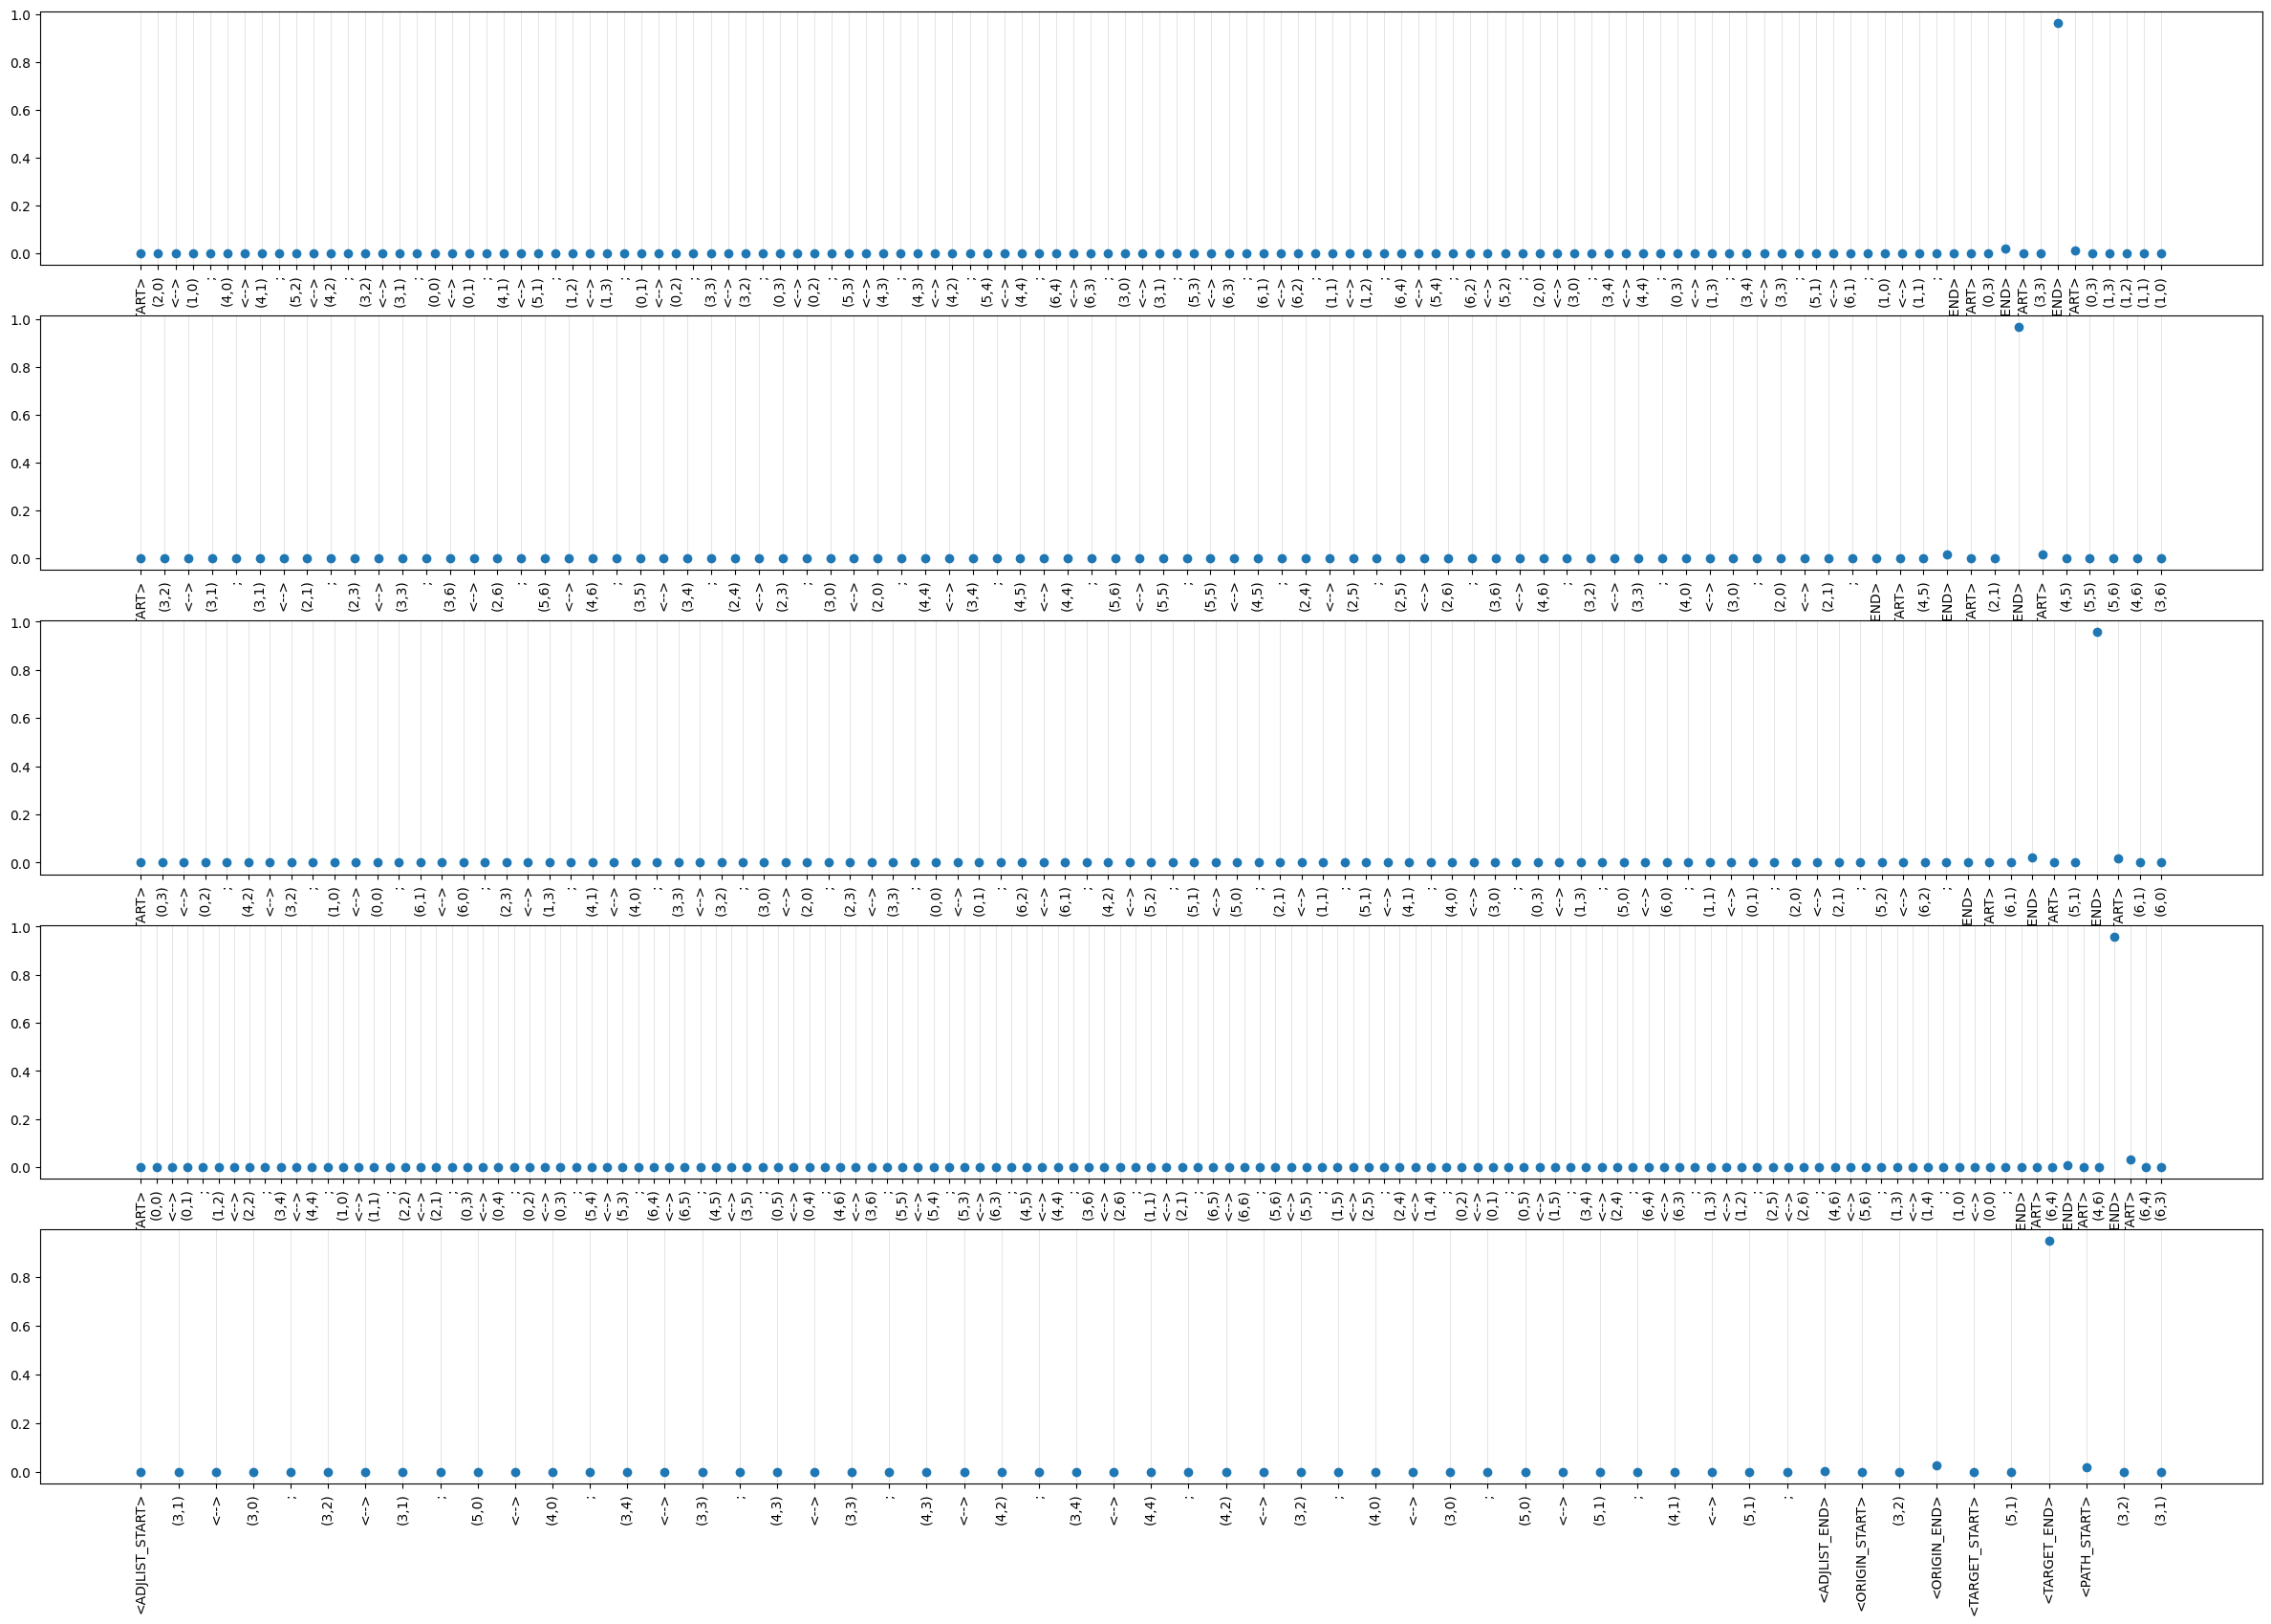

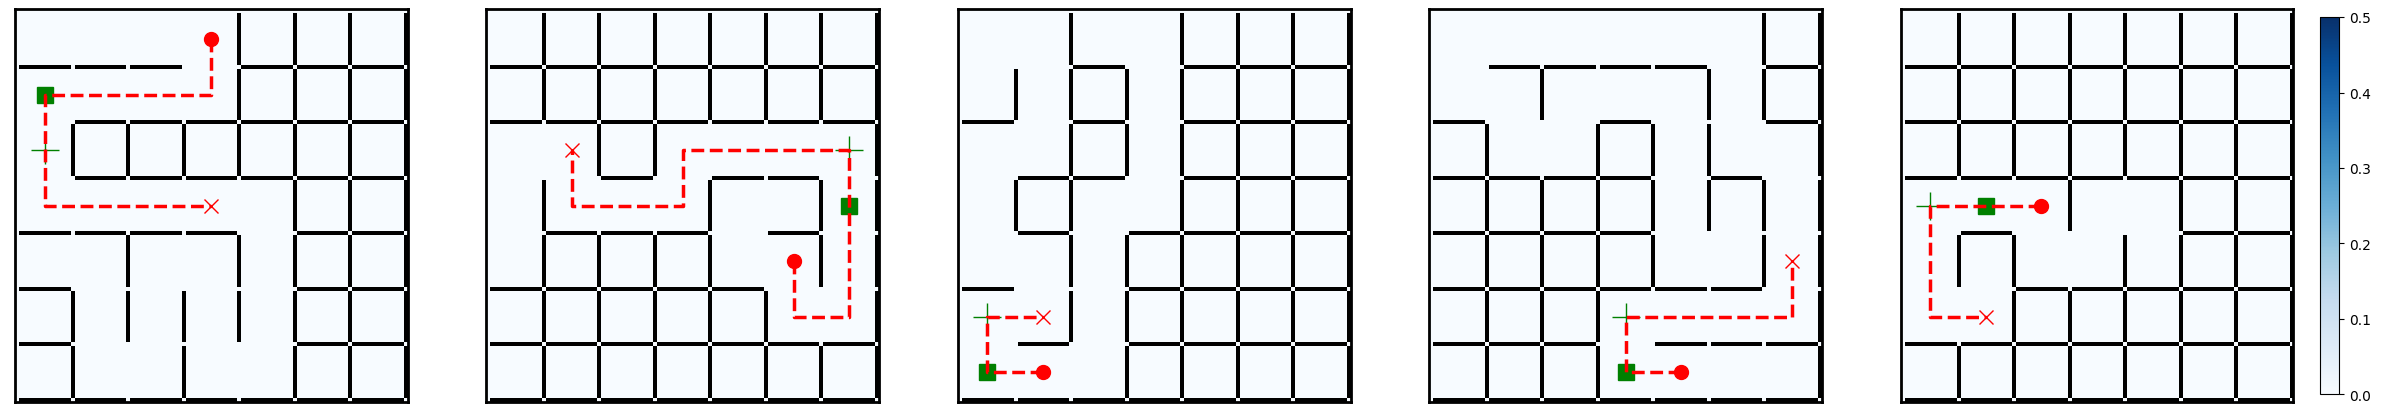

--------------------------------------------------------------------------------
head: layer_3.head_1, score: c = -0.16694348, attn_presoftmax.shape = (200, 201, 201)
<--> (6,1) ; (1,0) <--> (1,1) ; <ADJLIST_END> <ORIGIN_START> (0,3) <ORIGIN_END> <TARGET_START> (3,3) <TARGET_END> <PATH_START> (0,3) (1,3) (1,2) (1,1) (1,0)
0.0  0.0     0.0   0.0  0.0     0.0           0.0            0.0   0.0          0.0            0.0   0.0          0.0          0.0   0.0   0.0   0.9   0.0   
AxesSubplot(0.125,0.11;0.133621x0.77)
self.hide_colorbar = True
<--> (3,0) ; (2,0) <--> (2,1) ; <ADJLIST_END> <ORIGIN_START> (4,5) <ORIGIN_END> <TARGET_START> (2,1) <TARGET_END> <PATH_START> (4,5) (5,5) (5,6) (4,6) (3,6)
0.0  0.0     0.0   0.0  0.0     0.0           0.0            0.0   0.0          0.0            0.0   0.0          0.0          0.0   0.0   0.0   0.9   0.0   
AxesSubplot(0.285345,0.11;0.133621x0.77)
self.hide_colorbar = True
(0,1) ; (2,0) <--> (2,1) ; (5,2) <--> (6,2) ; <ADJLIST_END> <ORIGIN_STAR

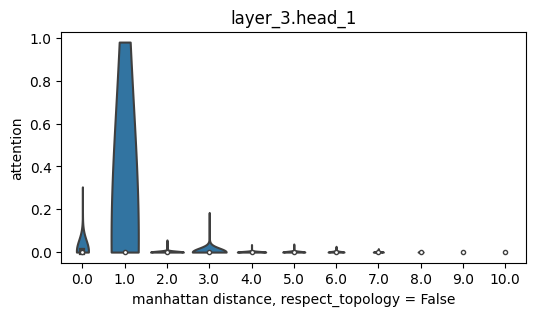

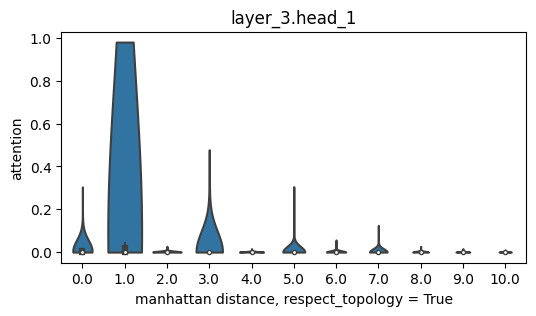

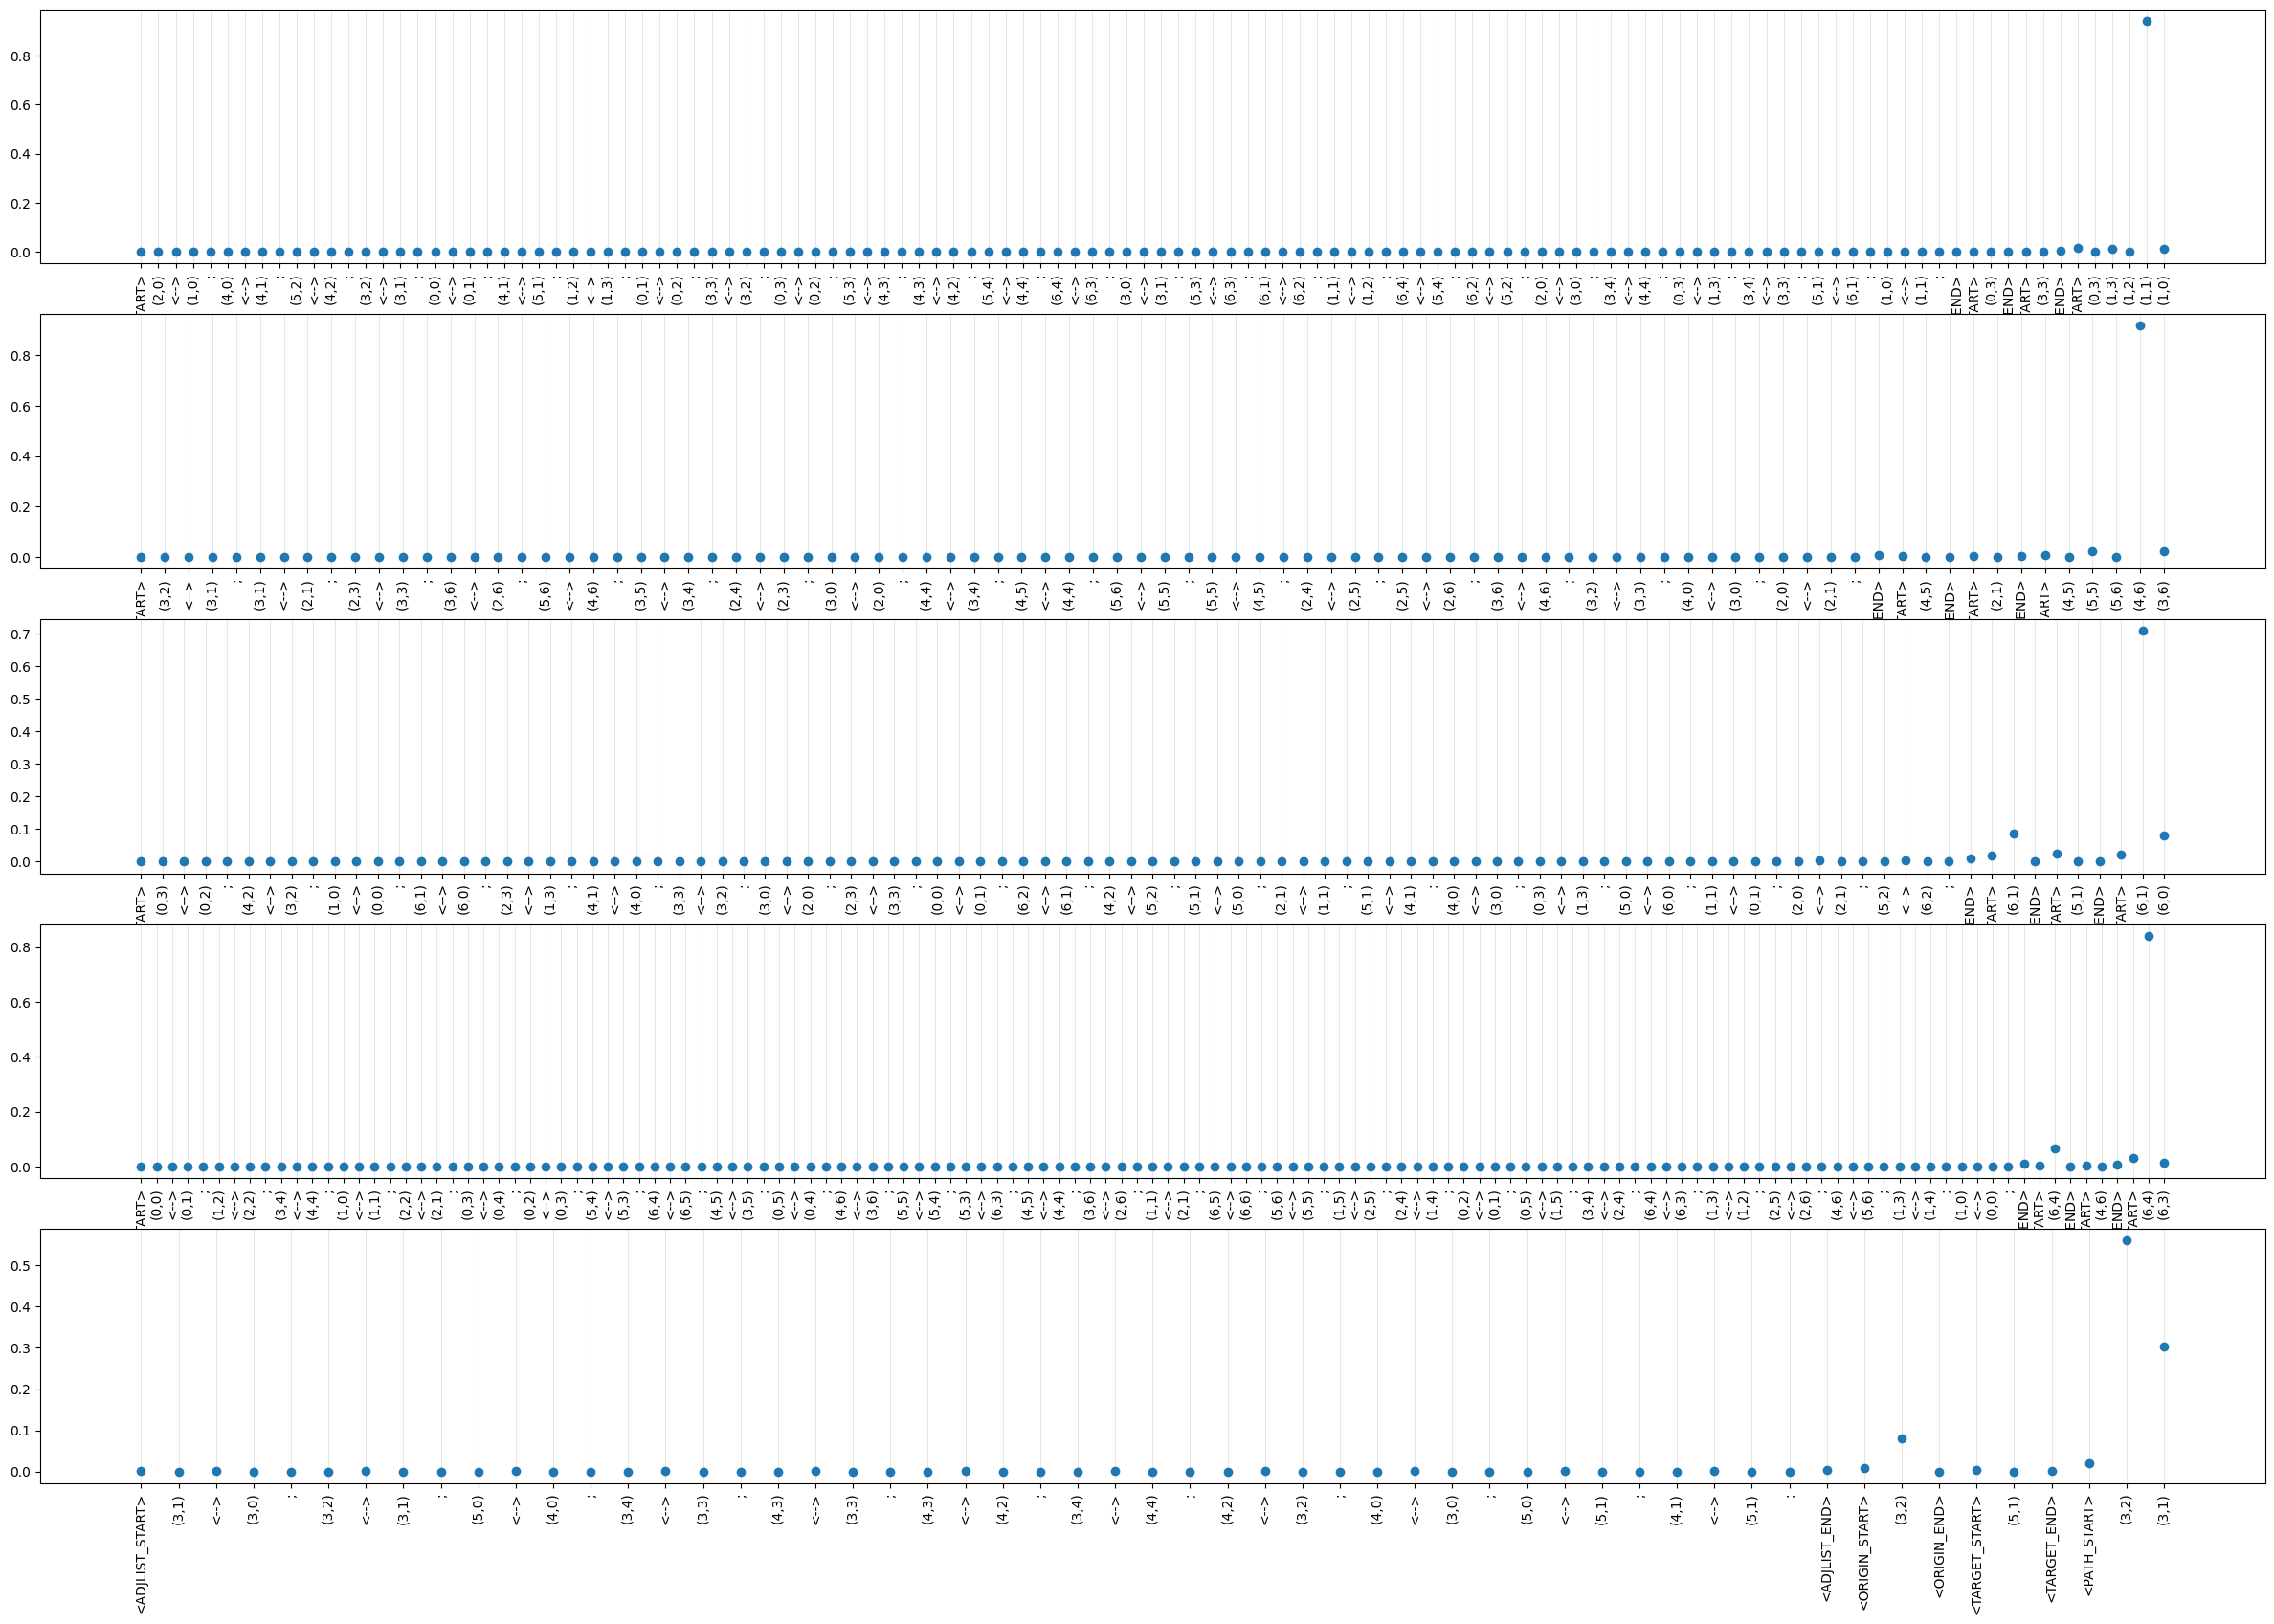

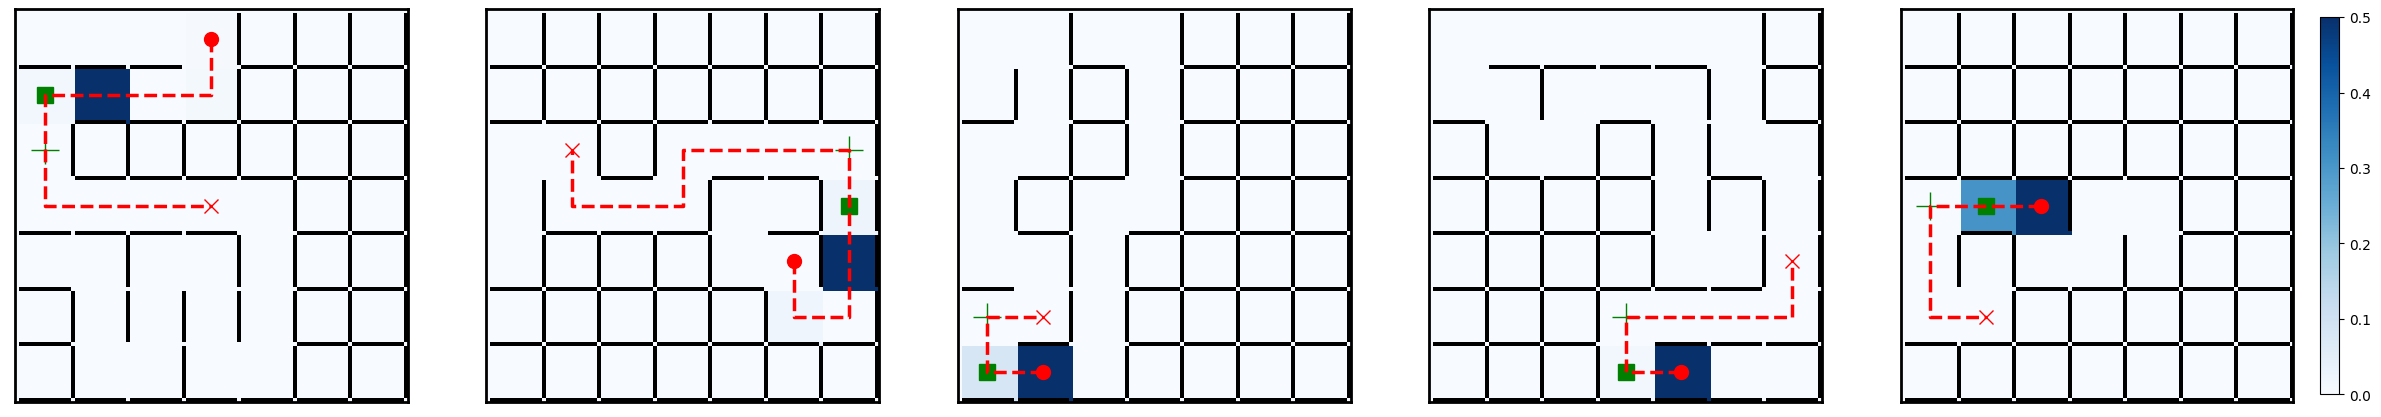

--------------------------------------------------------------------------------
head: layer_4.head_2, score: c = -0.15300508, attn_presoftmax.shape = (200, 201, 201)
<--> (6,1) ; (1,0) <--> (1,1) ; <ADJLIST_END> <ORIGIN_START> (0,3) <ORIGIN_END> <TARGET_START> (3,3) <TARGET_END> <PATH_START> (0,3) (1,3) (1,2) (1,1) (1,0)
0.0  0.0     0.0   0.0  0.0     0.0           0.0            0.0   0.0          0.0            0.0   0.0          0.0          0.0   0.0   0.0   0.0   0.0   
AxesSubplot(0.125,0.11;0.133621x0.77)
self.hide_colorbar = True
<--> (3,0) ; (2,0) <--> (2,1) ; <ADJLIST_END> <ORIGIN_START> (4,5) <ORIGIN_END> <TARGET_START> (2,1) <TARGET_END> <PATH_START> (4,5) (5,5) (5,6) (4,6) (3,6)
0.0  0.0     0.0   0.0  0.0     0.0           0.0            0.0   0.0          0.0            0.0   0.0          0.0          0.0   0.0   0.0   0.0   0.0   
AxesSubplot(0.285345,0.11;0.133621x0.77)
self.hide_colorbar = True
(0,1) ; (2,0) <--> (2,1) ; (5,2) <--> (6,2) ; <ADJLIST_END> <ORIGIN_STAR

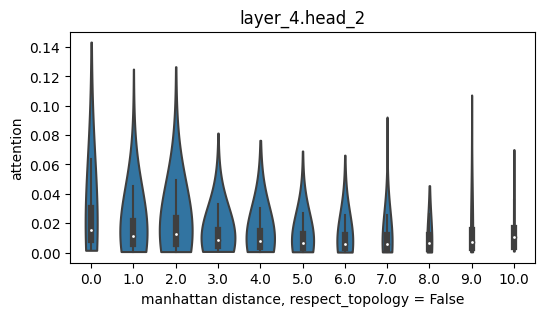

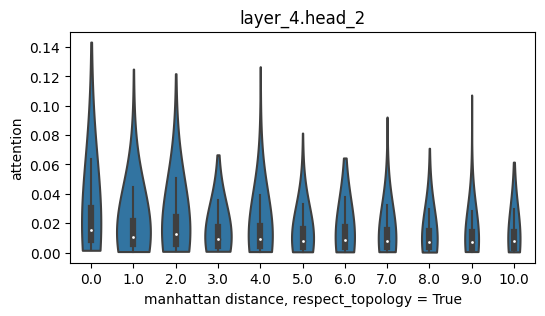

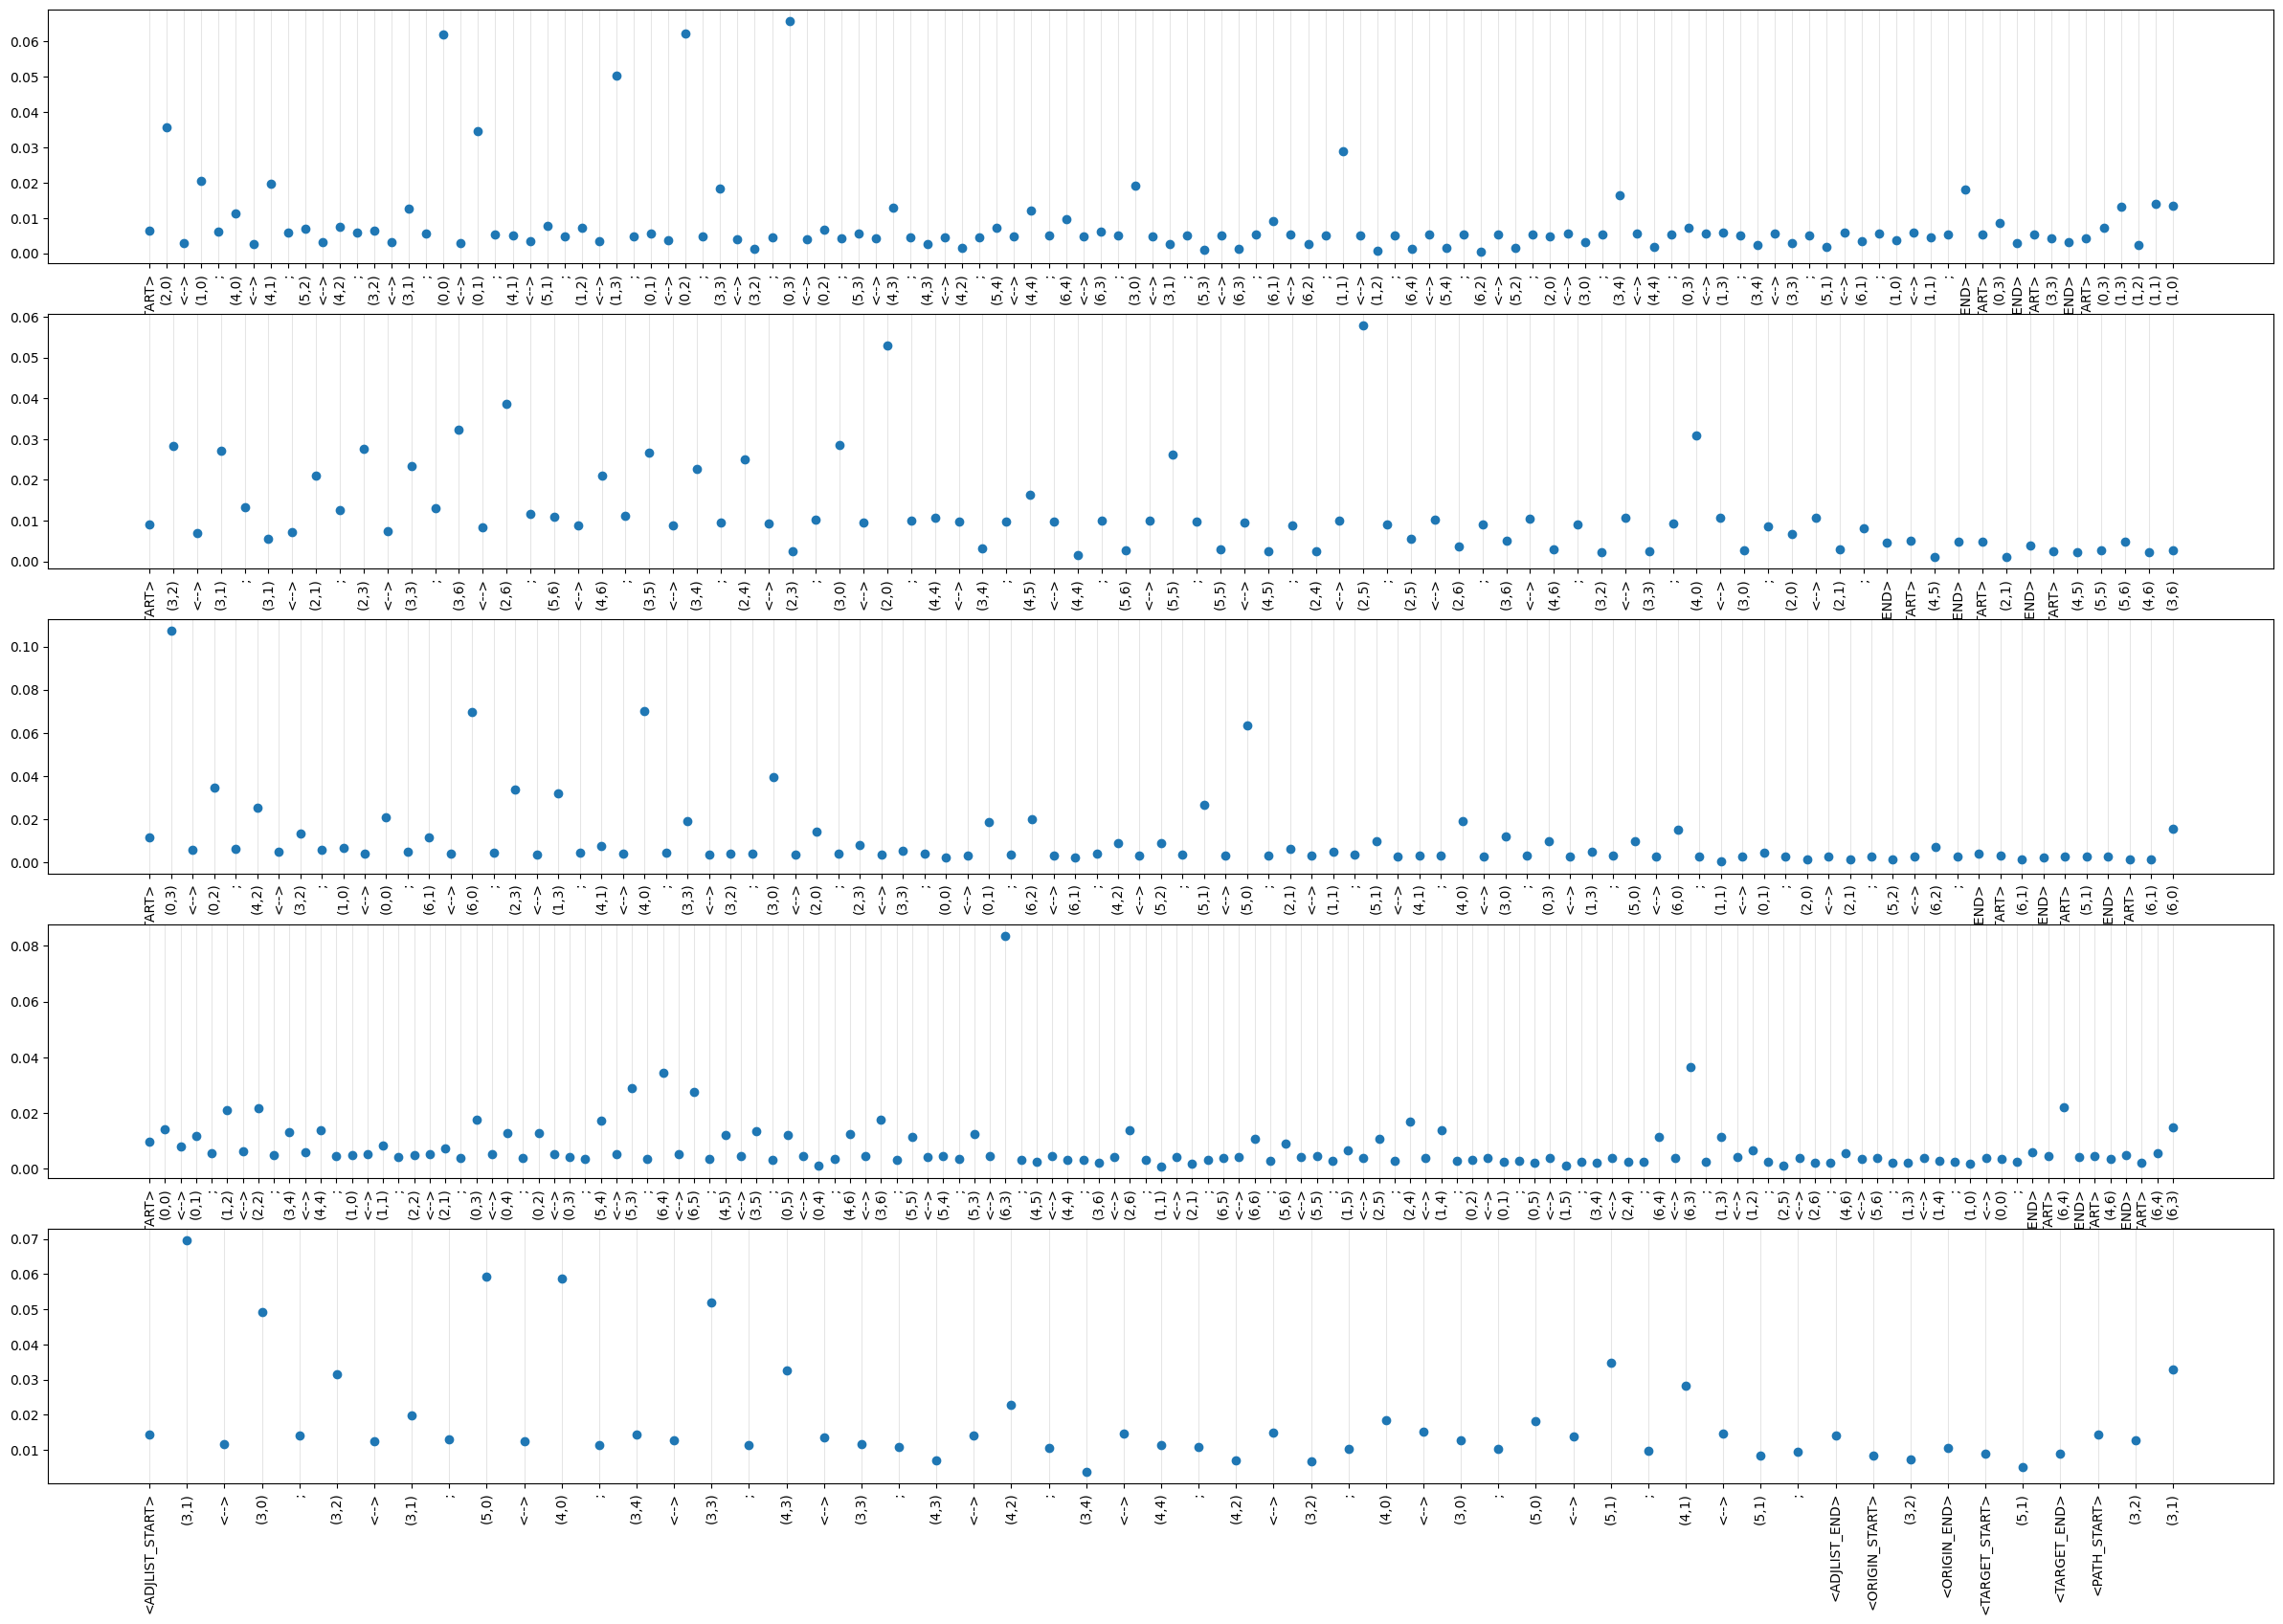

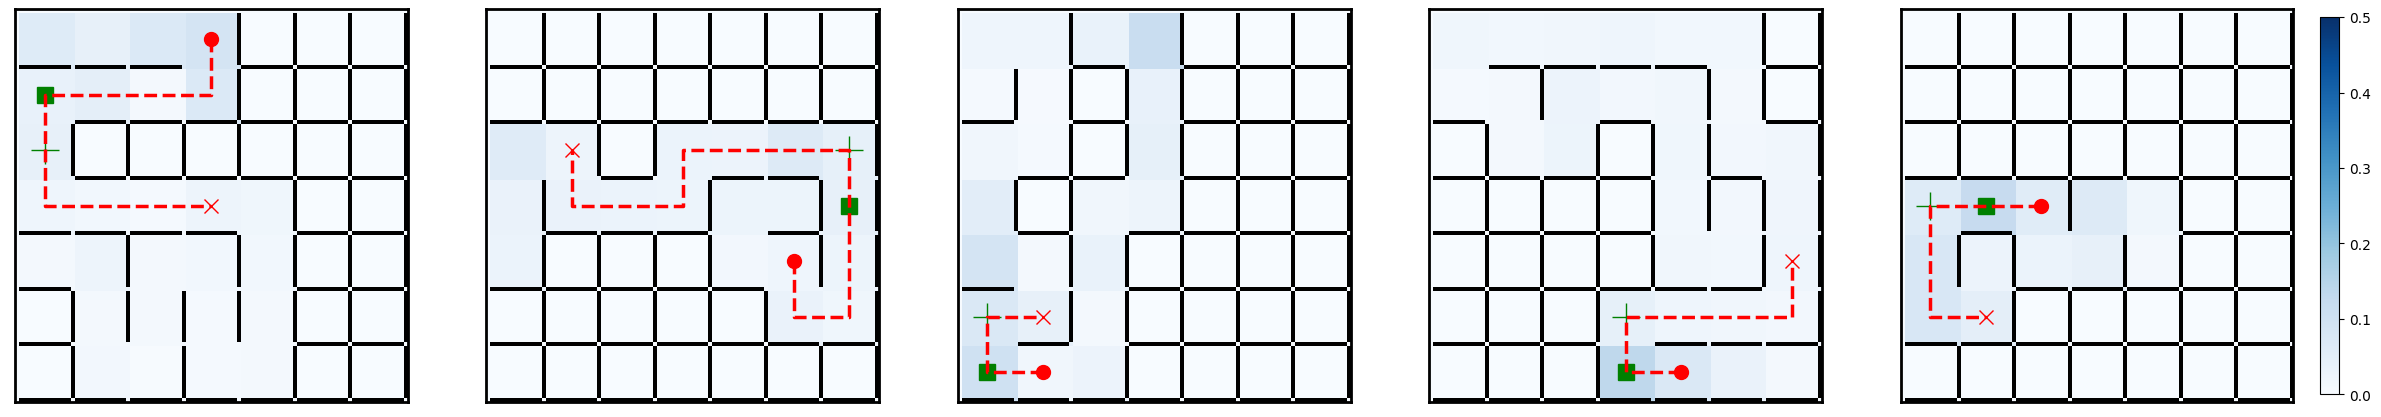

--------------------------------------------------------------------------------
head: layer_3.head_2, score: c = -0.08092911, attn_presoftmax.shape = (200, 201, 201)
<--> (6,1) ; (1,0) <--> (1,1) ; <ADJLIST_END> <ORIGIN_START> (0,3) <ORIGIN_END> <TARGET_START> (3,3) <TARGET_END> <PATH_START> (0,3) (1,3) (1,2) (1,1) (1,0)
0.0  0.0     0.0   0.0  0.0     0.0           0.0            0.0   0.0          0.0            0.0   0.0          0.0          0.0   0.0   0.0   0.2   0.3   
AxesSubplot(0.125,0.11;0.133621x0.77)
self.hide_colorbar = True
<--> (3,0) ; (2,0) <--> (2,1) ; <ADJLIST_END> <ORIGIN_START> (4,5) <ORIGIN_END> <TARGET_START> (2,1) <TARGET_END> <PATH_START> (4,5) (5,5) (5,6) (4,6) (3,6)
0.0  0.0     0.0   0.0  0.0     0.0           0.0            0.0   0.0          0.0            0.0   0.0          0.0          0.0   0.0   0.0   0.4   0.4   
AxesSubplot(0.285345,0.11;0.133621x0.77)
self.hide_colorbar = True
(0,1) ; (2,0) <--> (2,1) ; (5,2) <--> (6,2) ; <ADJLIST_END> <ORIGIN_STAR

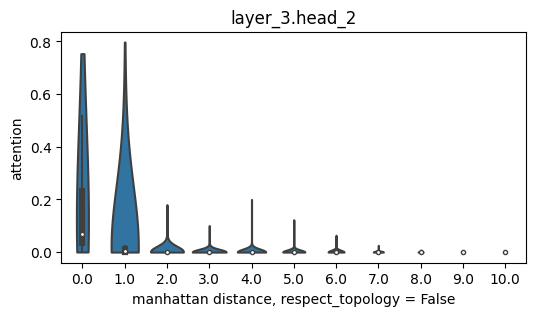

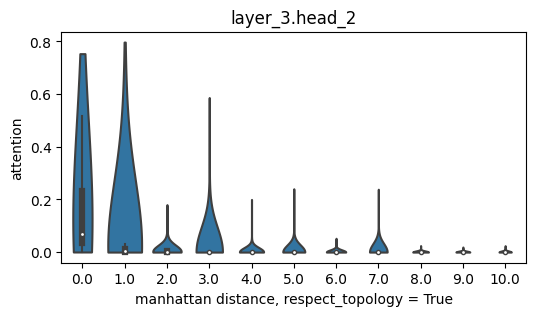

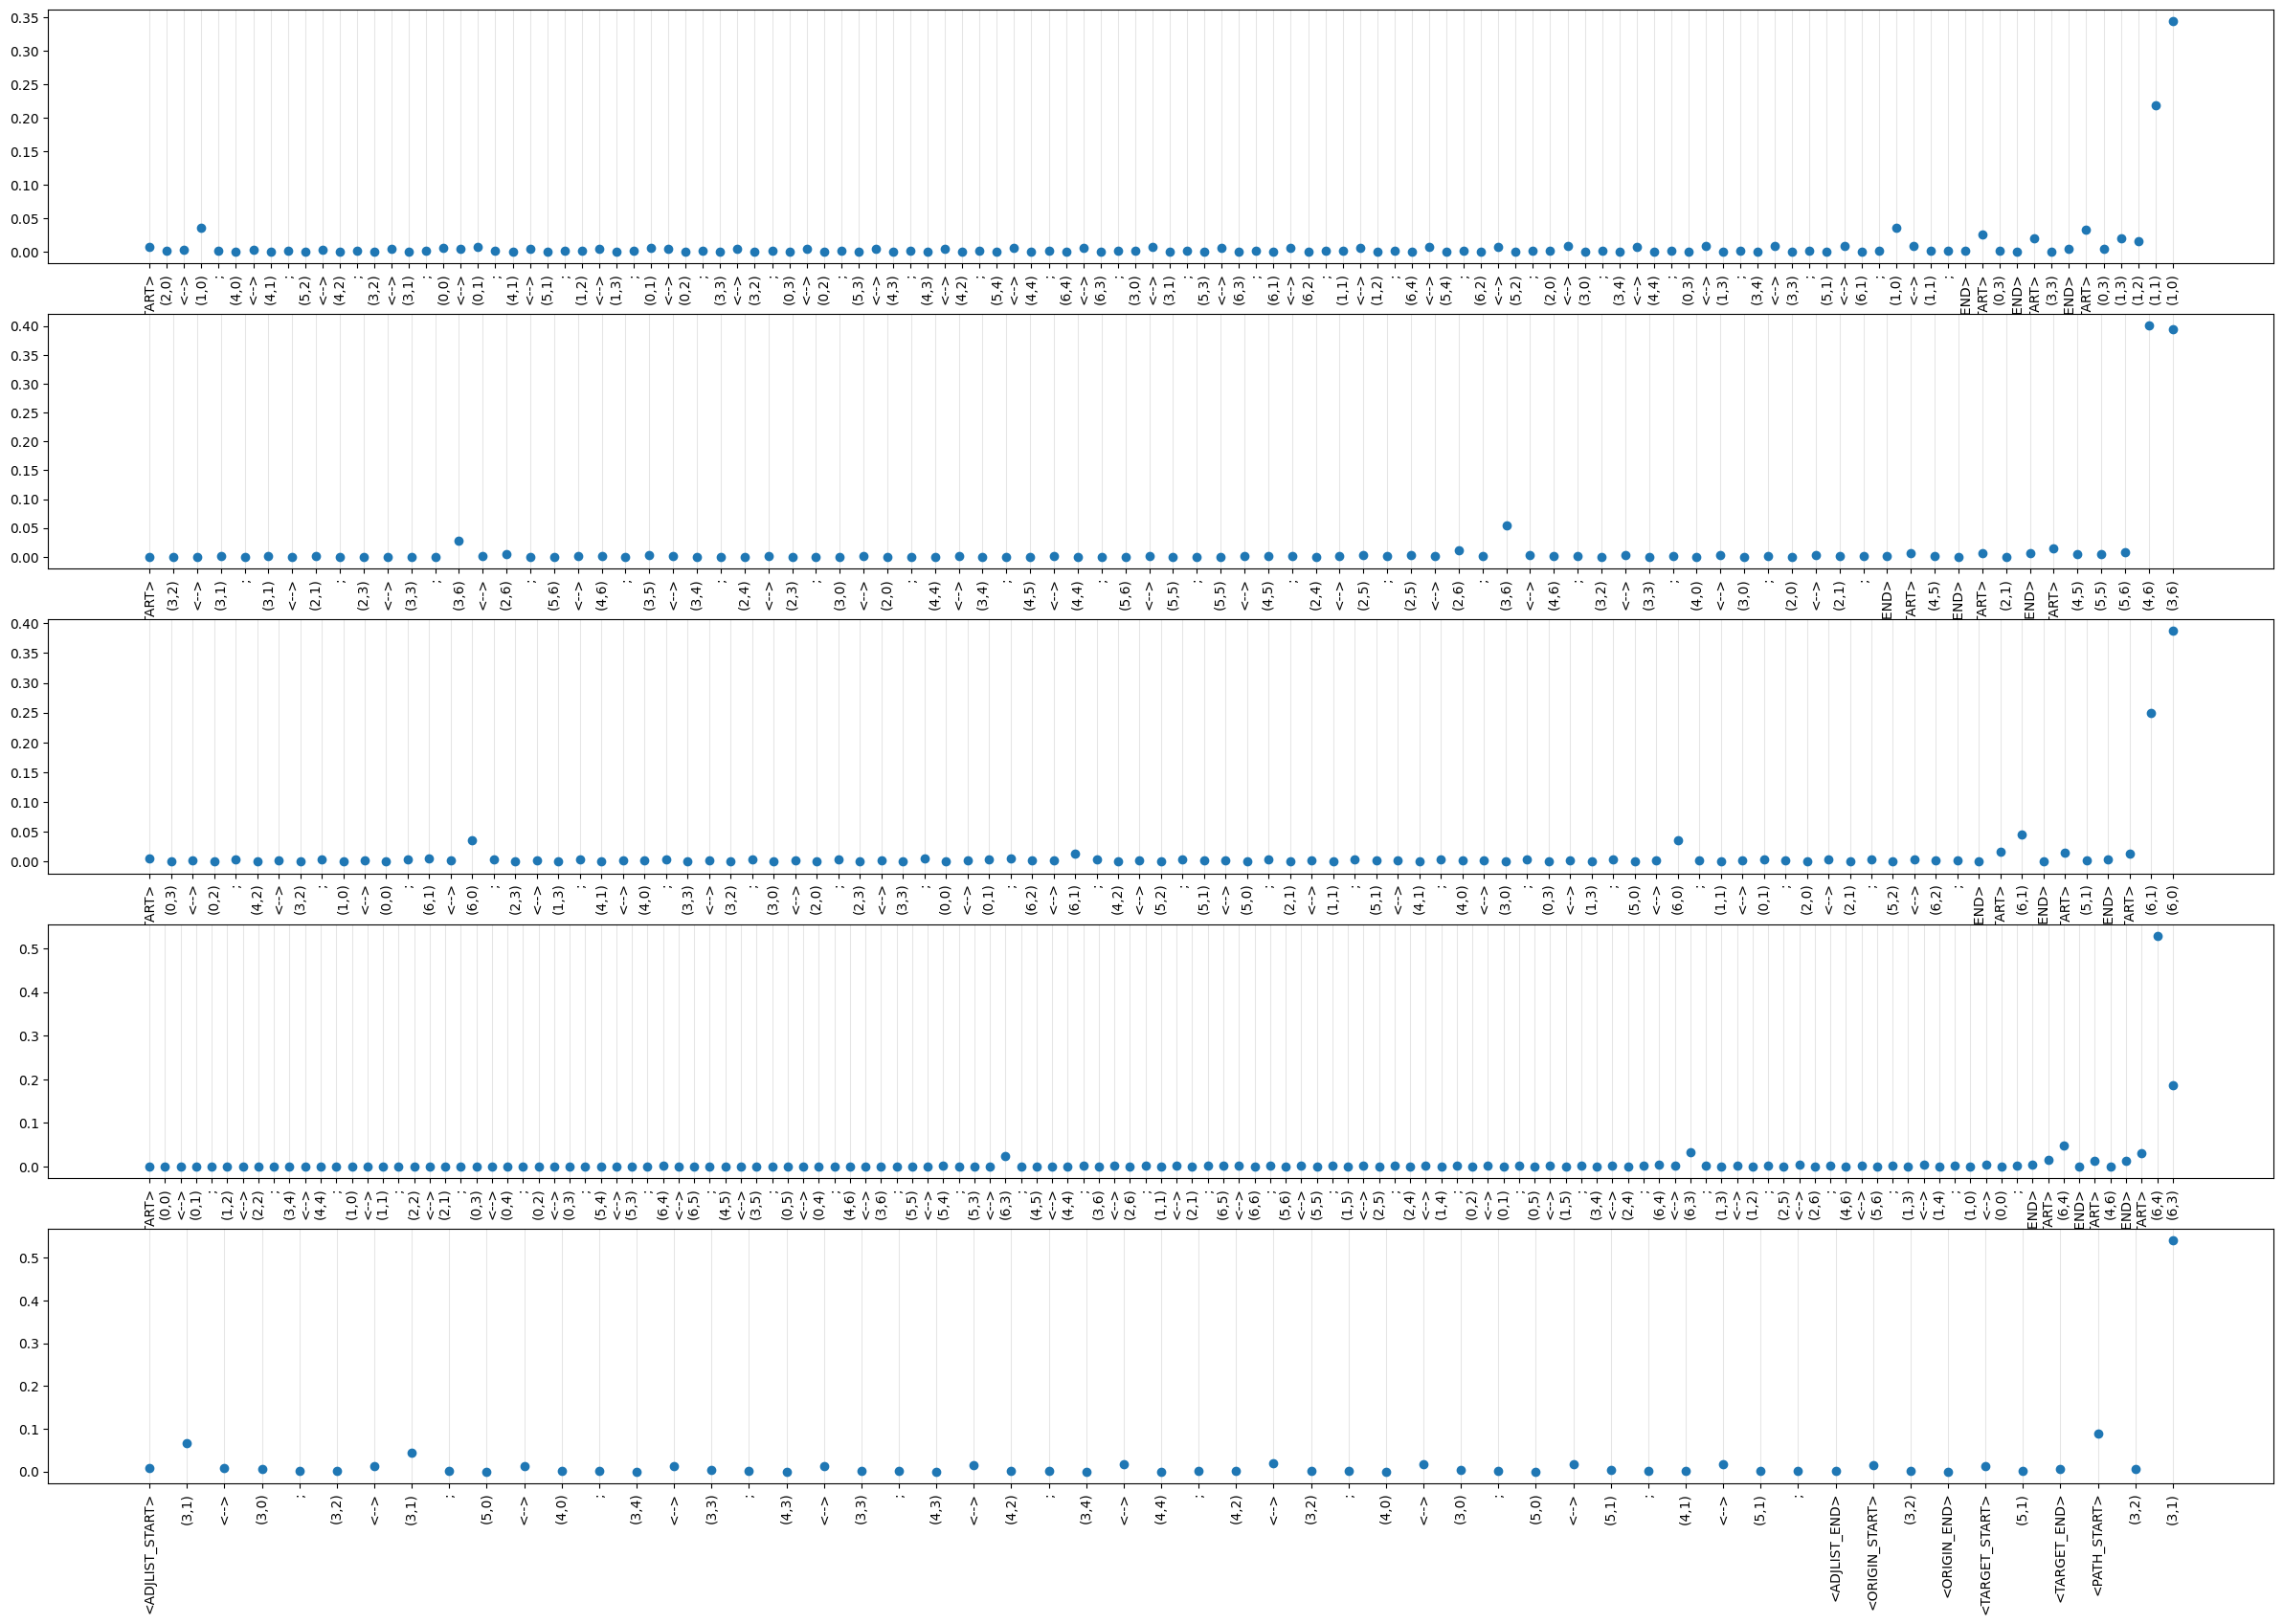

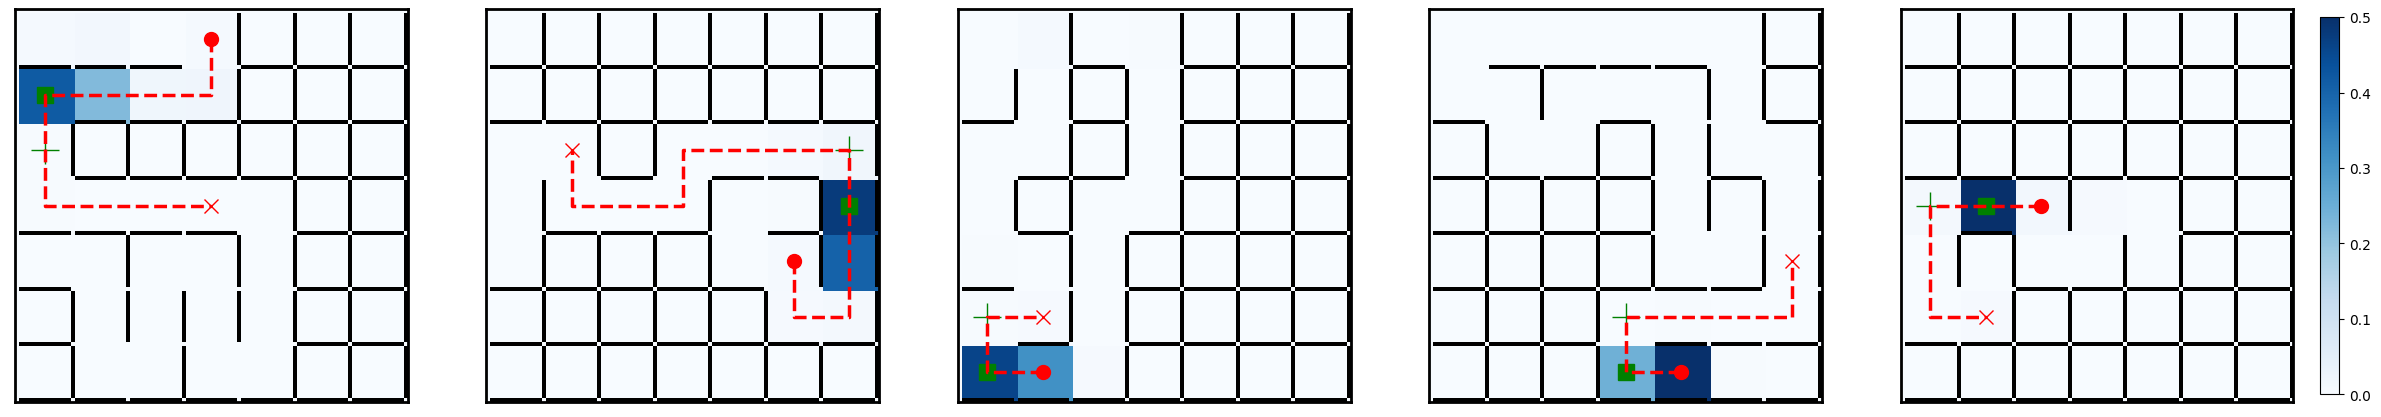

In [19]:

attn_final_tok_output = plot_attention_final_token(
    important_heads_scores=important_heads_scores,
    prompts=DATASET_PROMPTS,
    targets=DATASET_TARGETS,
    mazes=DATASET,
    tokenizer=TOKENIZER,
    n_mazes=5,
    last_n_tokens=20,
	softmax_attention=True,
    # exponentiate_scores=False,
    plot_colored_tokens=True,
    plot_scores=True,
    plot_attn_maze=True,
    maze_colormap_center=None,
	mazeplot_attn_cmap="Blues",
    show_all=True,
	plotshow_func=plotshow,
)


# TODO: total attention on coords within path as opposed to not in path?